# Topic Modeling — Text Files

In these lessons, we're learning about a text analysis method called *topic modeling*. This method will help us identify the main topics or discourses within a collection of texts or single text that has been separated into smaller text chunks.

___

## Dataset

### *New York Times* Obituaries

```{epigraph}
 Georgia O'Keeffe, the undisputed doyenne of American painting and a leader, with her husband, Alfred Stieglitz, of a crucial phase in the development and dissemination of American modernism, died yesterday at St. Vincent Hospital in Santa Fe, N.M.

--  Edith Evans Asbury, [Georgia O'Keefe Dead At 98](https://www.nytimes.com/1986/03/07/obituaries/georgia-o-keeffe-dead-at-98-shaper-of-modern-art-in-us.html)
```

In this particular lesson, we're going to use [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php), to topic model 379 obituaries published by *The New York Times*. This dataset is based on data originally collected by Matt Lavin for his *Programming Historian* [TF-IDF tutorial](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#lesson-dataset). I have re-scraped the obituaries so that the subject's name and death year is included in each text file name, and I have added 13 more ["Overlooked"](https://www.nytimes.com/interactive/2018/obituaries/overlooked.html) obituaries, including [Karen Spärck Jones](https://www.nytimes.com/2019/01/02/obituaries/karen-sparck-jones-overlooked.html), the computer scientist who introduced TF-IDF.

___

## Set MALLET Path

```{attention}
If you're working in this Jupyter notebook on your own computer, you'll need to have both the Java Development Kit and MALLET pre-installed. For set up instructions, please see [the previous lesson](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

If you're working in this Jupyter notebook in the cloud, then the Java Development Kit and Mallet will already be installed.
```

Since Little MALLET Wrapper is a Python package built around MALLET, we first need to tell it where the bigger, Java-based MALLET lives.

We're going to make a variable called `path_to_mallet` and assign it the file path of our MALLET program. We need to point it, specifically, to the "mallet" file inside the "bin" folder inside the "mallet-2.0.8" folder. 

In [1]:
path_to_mallet = 'mallet-2.0.8/bin/mallet'

If MALLET is located in another directory, then set your `path_to_mallet` to that file path.

## Install Packages

In [ ]:
#!pip install little_mallet_wrapper
#!pip install seaborn
#To install the most updated version of little_mallet_wrapper:
#!!pip install git+https://github.com/maria-antoniak/little-mallet-wrapper.git

## Import Packages

In [ ]:
#!pip install little_mallet_wrapper
#!pip install seaborn

Now let's `import` the `little_mallet_wrapper` and the data viz library `seaborn`.

In [2]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system.

## Get Training Data From Text Files

Before we topic model the *NYT* obituaries, we need to process the text files and prepare them for analysis. The steps below demonstrate how to process texts if your corpus is a collection of separate text files. In the next lesson, we'll demonstrate how to process texts that come from a CSV file.

```{note}
We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
```

To get the necessary text files, we're going to make a variable and assign it the file path for the directory that contains the text files.

In [3]:
directory = "../texts/history/NYT-Obituaries/"

Then we're going to use the `glob.gob()` function to make a list of all (`*`) the `.txt` files in that directory.

In [4]:
files = glob.glob(f"{directory}/*.txt")

In [5]:
files

['../texts/history/NYT-Obituaries/1852-Ada-Lovelace.txt',
 '../texts/history/NYT-Obituaries/1870-Robert-E-Lee.txt',
 '../texts/history/NYT-Obituaries/1875-Andrew-Johnson.txt',
 '../texts/history/NYT-Obituaries/1877-Bedford-Forrest.txt',
 '../texts/history/NYT-Obituaries/1880-Lucretia-Mott.txt',
 '../texts/history/NYT-Obituaries/1882-Charles-Darwin.txt',
 '../texts/history/NYT-Obituaries/1885-Ulysses-Grant.txt',
 '../texts/history/NYT-Obituaries/1886-Mary-Ewing-Outerbridge.txt',
 '../texts/history/NYT-Obituaries/1887-Emma-Lazarus.txt',
 '../texts/history/NYT-Obituaries/1888-Louisa-M-Alcott.txt',
 '../texts/history/NYT-Obituaries/1891-P-T-Barnum.txt',
 '../texts/history/NYT-Obituaries/1894-R-L-Stevenson.txt',
 '../texts/history/NYT-Obituaries/1895-Fred-Douglass.txt',
 '../texts/history/NYT-Obituaries/1896-Harriet-Beecher-Stowe.txt',
 '../texts/history/NYT-Obituaries/1900-Nietzsche.txt',
 '../texts/history/NYT-Obituaries/1900-Stephen-Crane.txt',
 '../texts/history/NYT-Obituaries/1901-Benj

## Process Texts

```
little_mallet_wrapper.process_string(text, numbers='remove')
````

Next we process our texts with the function `little_mallet_wrapper.process_string()`. This function will take every individual text file, transform all the text to lowercase as well as remove stopwords, punctuation, and numbers, and then add the processed text to our master list `training_data`.

:::{admonition,pythonreview} Python Review  
Take a moment to study this code and reflect about what's happening here. This is a very common Python pattern! We make an empty list, iterate through every file, open and read each text file, process the texts, and finally append them to the previously empty list.  
:::

In [6]:
training_data = []
for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)

We're also making a master list of the original text of the obituaries for future reference.

In [7]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

## Process Titles

Here we extract the relevant part of each file name by using [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem), which conveniently extracts just the last part of the file path without the ".txt" file extension. Because each file name includes the obituary subject's name as well as the year that the subject died, we're going to use this information as a title or label for each obituary.

In [8]:
obit_titles = [Path(file).stem for file in files]

In [9]:
obit_titles

['1852-Ada-Lovelace',
 '1870-Robert-E-Lee',
 '1875-Andrew-Johnson',
 '1877-Bedford-Forrest',
 '1880-Lucretia-Mott',
 '1882-Charles-Darwin',
 '1885-Ulysses-Grant',
 '1886-Mary-Ewing-Outerbridge',
 '1887-Emma-Lazarus',
 '1888-Louisa-M-Alcott',
 '1891-P-T-Barnum',
 '1894-R-L-Stevenson',
 '1895-Fred-Douglass',
 '1896-Harriet-Beecher-Stowe',
 '1900-Nietzsche',
 '1900-Stephen-Crane',
 '1901-Benjamin-Harrison',
 '1901-Queen-Victoria',
 '1901-William-McKinley',
 '1902-Elizabeth-Cady-Stanton',
 '1903-Emily-Warren-Roebling',
 '1903-James-M-N-Whistler',
 '1906-Susan-B-Anthony',
 '1907-Qiu-Jin',
 '1908-Cleveland',
 '1909-Geronimo',
 '1909-Sarah-Orne-Jewett',
 '1910-Florence-Nightingale',
 '1910-Tolstoy',
 '1910-William-James',
 '1911-Joseph-Pulitzer',
 '1914-Alfred-Thayer-Mahan',
 '1914-John-Muir',
 '1914-John-P-Holland',
 '1915-B-T-Washington',
 '1915-F-W-Taylor',
 '1916-J-J-Hill',
 '1916-Jack-London',
 '1916-Martian-Theory',
 '1917-Hilaire-G-E-Degas',
 '1919-Anna-H-Shaw',
 '1919-C-J-Walker',
 '1

## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [10]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 379
Mean Number of Words per Document: 1314.7
Vocabulary Size: 35973


According to this little report, we have 378 documents (or obituaries) that average 1345 words in length.

## Training the Topic Model

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function. As you can see above, however, this function requires 6 different arguments and file paths to run properly. 

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [11]:
num_topics = 15

### Set Training Data

We already made a variable called `training_data`, which includes all of our processed obituary texts, so we can just set it equal to itself.

In [12]:
training_data = training_data

### Set Topic Model Output Files

Finally, we need to tell Little MALLET Wrapper where to find and output all of our topic modeling results. The code below will set Little MALLET Wrapper up to output your results inside a directory called "topic-model-output" and a subdirectory called "NYT-Obits", all of which will be inside your current directory.

If you'd like to change this output location, simply change `output_directory_path` below.

In [13]:
#Change to your desired output directory
output_directory_path = 'topic-model-output/NYT-Obits'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Import Data

Now we import our training data with `little_mallet_wrapper.import_data()`.

In [14]:
little_mallet_wrapper.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


### Train Topic Model

Finally, we train our topic model with `little_mallet_wrapper.train_topic_model()`. The topic model should take about 45 seconds to 1 minute to fully train and complete. If you want, you can look at your Terminal or PowerShell while it's running and see what the model looks like as it trains.

In [15]:
little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      num_topics)

Training topic model...
Complete


When the topic model finishes, it will output your results to your `output_directory_path`.

## Display Topics and Top Words

To examine the 15 topics that the topic model extracted from the *NYT* obituaries, run the cell below. This code uses the `little_mallet_wrapper.load_topic_keys()` function to read and process the MALLET topic model output from your computer, specifically the file "mallet.topic_keys.15".

>*Take a minute to read through every topic. Reflect on what each topic seems to capture as well as how well you think the topics capture the broad themes of the entire collection. Note any oddities, outliers, or inconsistencies.*

In [16]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['soviet', 'party', 'mao', 'china', 'communist', 'union', 'chinese', 'stalin', 'moscow', 'deng', 'chiang', 'khrushchev', 'communists', 'economic', 'political', 'military', 'revolution', 'leader', 'brezhnev', 'power']

✨Topic 1✨

['miss', 'film', 'theater', 'movie', 'broadway', 'films', 'stage', 'hollywood', 'movies', 'actor', 'made', 'director', 'show', 'television', 'actress', 'star', 'love', 'role', 'dance', 'play']

✨Topic 2✨

['king', 'israel', 'gandhi', 'minister', 'black', 'india', 'peace', 'said', 'negro', 'arab', 'jewish', 'prime', 'israeli', 'white', 'egypt', 'british', 'sadat', 'civil', 'president', 'begin']

✨Topic 3✨

['death', 'years', 'made', 'great', 'london', 'upon', 'england', 'died', 'church', 'queen', 'english', 'world', 'year', 'prince', 'married', 'lord', 'last', 'one', 'life', 'two']

✨Topic 4✨

['general', 'grant', 'gen', 'army', 'president', 'men', 'upon', 'macarthur', 'command', 'pershing', 'war', 'union', 'military', 'made', 'troops', 'service', 'ha

## Load Topic Distributions

MALLET also calculates the likely mixture of these topics for every single obituary in the corpus. This mixture is really a probability distribution, that is, the probability that each topic exists in the document. We can use these probability distributions to examine which of the above topics are strongly associated with which specific obituaries.

To get the topic distributions, we're going to use the `little_mallet_wrapper.load_topic_distributions()` function, which will read and process the MALLET topic model output, specifically the file "mallet.topic_distributions.15". 

In [17]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

If we look at the 32nd topic distribution in this list of `topic_distributions`, which corresponds to Marilyn Monroe's obituary, we will see a list of 15 probabilities. This  list corresponds to the likelihood that each of the 15 topics exists in Marilyn Monroe's obituary.

In [18]:
topic_distributions[32]

[0.0019408054342552159,
 0.003396409509946628,
 0.00048520135856380397,
 0.054342552159146046,
 0.022319262493934983,
 0.020863658418243572,
 0.1824357108199903,
 0.00048520135856380397,
 0.24648229015041243,
 0.0077632217370208634,
 0.21445900048520136,
 0.058709364386220285,
 0.009218825812712276,
 0.15041242115477924,
 0.026686074721009218]

It's a bit easier to understand if we pair these probabilities with the topics themselves. As you can see below, Topic 0 "miss film theater movie broadway films" has a relatively high probability of existing in Marilyn Monroe's obituary `.202` while Topic 5 "soviet hitler german germany stalin union" has a relatively low probability `.002`. This seems to comport with what we know about Marilyn Monroe.

In [19]:
obituary_to_check = "1962-Marilyn-Monroe"

obit_number = obit_titles.index(obituary_to_check)

print(f"Topic Distributions for {obit_titles[obit_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[obit_number])):
    print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for 1962-Marilyn-Monroe

✨Topic 0 ['soviet', 'party', 'mao', 'china', 'communist', 'union'] ✨
Probability: 0.013

✨Topic 1 ['miss', 'film', 'theater', 'movie', 'broadway', 'films'] ✨
Probability: 0.18

✨Topic 2 ['king', 'israel', 'gandhi', 'minister', 'black', 'india'] ✨
Probability: 0.001

✨Topic 3 ['death', 'years', 'made', 'great', 'london', 'upon'] ✨
Probability: 0.019

✨Topic 4 ['general', 'grant', 'gen', 'army', 'president', 'men'] ✨
Probability: 0.021

✨Topic 5 ['president', 'state', 'court', 'roosevelt', 'house', 'justice'] ✨
Probability: 0.004

✨Topic 6 ['one', 'would', 'years', 'life', 'could', 'man'] ✨
Probability: 0.321

✨Topic 7 ['music', 'band', 'jazz', 'baseball', 'played', 'piano'] ✨
Probability: 0.033

✨Topic 8 ['first', 'became', 'time', 'made', 'american', 'took'] ✨
Probability: 0.156

✨Topic 9 ['war', 'united', 'states', 'world', 'nations', 'government'] ✨
Probability: 0.001

✨Topic 10 ['miss', 'university', 'professor', 'institute', 'research', 

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the `little_mallet_wrapper.plot_categories_by_topics_heatmap()` function.

We have everything we need for the heatmap except for our list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [20]:
target_labels = ['1852-Ada-Lovelace', '1885-Ulysses-Grant',
                 '1900-Nietzsche', '1931-Ida-B-Wells', '1940-Marcus-Garvey',
                 '1941-Virginia-Woolf', '1954-Frida-Kahlo', '1962-Marilyn-Monroe',
                 '1963-John-F-Kennedy', '1964-Nella-Larsen', '1972-Jackie-Robinson',
                 '1973-Pablo-Picasso', '1984-Ray-A-Kroc','1986-Jorge-Luis-Borges', '1991-Miles-Davis',
                 '1992-Marsha-P-Johnson', '1993-Cesar-Chavez']

If you'd like to make a random list of target labels, you can uncomment and run the cell below.

In [21]:
#import random
#target_labels = random.sample(obit_titles, 10)

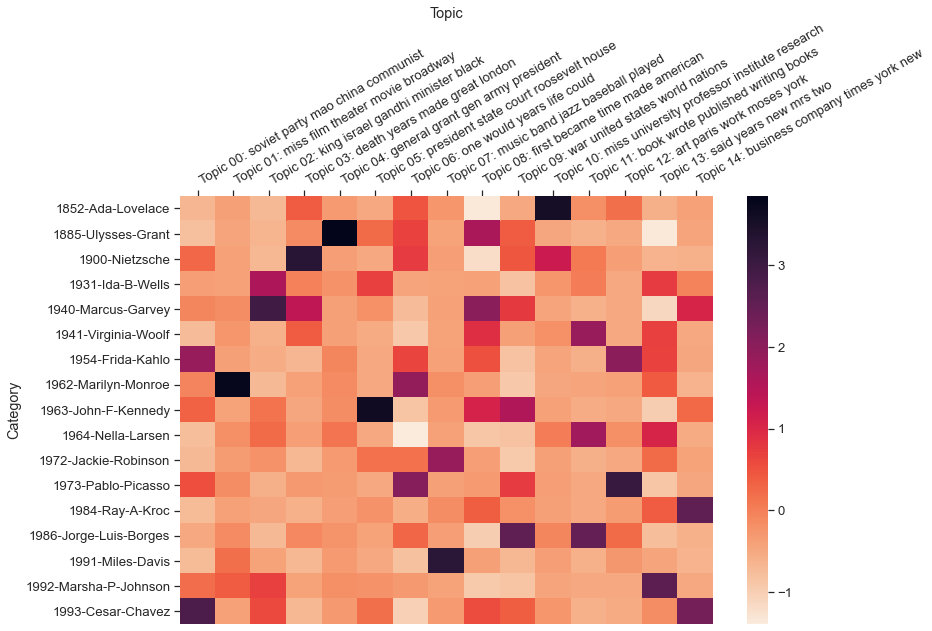

In [22]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(obit_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic. For example, if you scan across the row of Marilyn Monroe, you can see a dark square for the topic "miss film theater movie theater broadway". If you scan across the row of Ada Lovelace, an English mathematician who is now recognized as the first computer programmer, according to her [NYT obituary](https://www.nytimes.com/interactive/2018/obituaries/overlooked-ada-lovelace.html), you can see a dark square for "university professor research science also".

The `plot_categories_by_topics_heatmap()` function also helpfully outputs a PDF of the heatmap to `output_directory_path + '/categories_by_topics.pdf'`. We can download this PDF and explore it in more detail or embed it in an article or blog post!

In [23]:
from IPython.display import IFrame
IFrame("topic-model-output/NYT-obits/categories_by_topics.pdf", width=1000, height=600)

## Display Top Titles Per Topic

We can also display the obituaries that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

Because most of the obituaries in our corpus are pretty long, however, it will be more useful for us to simply display the title of each obituary, rather than the entire document—at least as a first step. To do so, we'll first need to make two dictionaries, which will allow us to find the corresponding obituary title and the original text from a given training document.

In [24]:
training_data_obit_titles = dict(zip(training_data, obit_titles))
training_data_original_text = dict(zip(training_data, original_texts))

Then we'll make our own function `display_top_titles_per_topic()` that will display the top text titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [25]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_obit_titles[document] + "\n")
    return

**Topic 0**

To display the top 5 obituary titles with the highest probability of containing Topic 0, we will run:

In [26]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5)

✨Topic 0✨

['soviet', 'party', 'mao', 'china', 'communist', 'union', 'chinese', 'stalin', 'moscow', 'deng', 'chiang', 'khrushchev', 'communists', 'economic', 'political', 'military', 'revolution', 'leader', 'brezhnev', 'power']

0.4112 1997-Deng-Xiaoping

0.3602 1982-Leonid-Brezhnev

0.3246 1976-Mao-Tse-Tung

0.3204 1971-Khrushchev

0.3141 1975-Chiang-Kai-shek



**Topic 0 Label**: 

Hollywood (Double-click this cell to enter your own label)

**Topic 9**

To display the top 5 obituary titles with the highest probability of containing Topic 9, we will run:

In [27]:
display_top_titles_per_topic(topic_number=9, number_of_documents=5)

✨Topic 9✨

['war', 'united', 'states', 'world', 'nations', 'government', 'hitler', 'german', 'germany', 'general', 'france', 'french', 'secretary', 'foreign', 'army', 'europe', 'peace', 'political', 'minister', 'military']

0.4393 1945-Adolf-Hitler

0.4338 1970-Edouard-Daladier

0.395 1954-Getulio-Vargas

0.3747 1975-Franco

0.3494 1961-Hammarskjold



**Topic 9 Label**: 

Global Affairs (Double-click this cell to enter your own label)

**Topic 8**

To display the top 7 obituaries with the highest probability of containing Topic 8, we will run:

In [28]:
display_top_titles_per_topic(topic_number=8, number_of_documents=7)

✨Topic 8✨

['first', 'became', 'time', 'made', 'american', 'took', 'said', 'year', 'one', 'day', 'country', 'early', 'began', 'three', 'left', 'although', 'days', 'end', 'long', 'several']

0.527 1914-John-P-Holland

0.359 1973-Eddie-Rickenbacker

0.3198 1945-George-Patton

0.292 1947-Henry-Ford

0.2835 1909-Geronimo

0.2827 1966-Chester-Nimitz

0.2824 1948-John-Pershing



**Topic 8 Label**: 

Authors (Double-click this cell to enter your own label)

## Display Topic Words in Context of Original Text

Often it's useful to actually look at the document that has ranked highly for a given topic and puzzle out why it ranks so highly.

To display the original obituary texts that rank highly for a given topic, with the relevant topic words **bolded** for emphasis, we are going to make the function `display_bolded_topic_words_in_context()`.

In the cell below, we're importing two special Jupyter notebook display modules, which will allow us to make the relevant topic words **bolded**, as well as the regular expressions library `re`, which will allow us to find and replace the correct words.

In [29]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        
        print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")
        
        probability = f"✨✨✨\n\n**{probability}**"
        obit_title = f"**{training_data_obit_titles[document]}**"
        original_text = training_data_original_text[document]
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text:
                original_text = re.sub(f"\\b{word}\\b", f"**{word}**", original_text)

        display(Markdown(probability)), display(Markdown(obit_title)), display(Markdown(original_text))
    return

**Topic 3**

To display the top 3 original obituaries with the highest probability of containing Topic 0 and with relevant topic words bolded, we will run:

In [30]:
display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3)

✨Topic 3✨

['death', 'years', 'made', 'great', 'london', 'upon', 'england', 'died', 'church', 'queen', 'english', 'world', 'year', 'prince', 'married', 'lord', 'last', 'one', 'life', 'two']



✨✨✨

**0.48268830628381193**

**1901-Queen-Victoria**

January 23, 1901

 OBITUARY

 Longest Reign In English History

 By THE NEW YORK TIMES

 The reign of Queen Victoria, who came to the throne of her ancestors in 1837, was the longest in English history; indeed, it was **one** of the longest in the history of Europe, whether the ancient nations or the modern be considered. English reigns remarkable for length are those of Henry VI., 39 **years**; Henry VIII., 38; Elizabeth, 45; Edward III., 50; Henry III., 56, and George III., 60. It thus appears that the only reigns besides Victoria's that exceeded fifty **years** are those of Henry III. and George III. In the case of Henry, however, it is to be borne in mind that he ascended the throne when only a boy of ten, with Pembroke and others as Regents, while George III. during the **last** ten **years** of his **life** was a hopeless lunatic, and his son served as Regent until his **death**. Victoria's more than half century of reign began when she was a grown-up woman and legally of age. No Regent was necessary. At the time of her **death** also she was the oldest monarch that ever ruled Great Britain.

 French history, however, supplies us with a reign considerably longer than hers, that of Louis XIV., who sat on the throne of France from 1643 until 1715, a period of seventy-**two** **years**, of which only nine belong to the Regency of Anne of Austria. But German history yields us no parallel. Neither the Carlovingian, the Hohenstaufen, the Hapsburg, nor the Austrian line affords a single reign that exceeded fifty **years** in length. Nor does the long line of Roman Emperors who ruled in Rome supply an instance of such length of regal days in power. The longest reign was that of Constantine the

 Great, 31 **years**; the next longest that of Valentinian III., 30 **years**, while reigns so celebrated in Roman annals as those of Tiberius, Claudius, Domitian, Trajan, and Diocletian extended over only 23, 13, 15, 19, and 21 **years**, respectively. If we include the later Eastern Empire, **one** reign of 56 **years** (Basil II., who had a colleague for seven **years**) is found and **one** of 48 (Constantine VII., who had several colleagues). But this is the best Rome can show.

 In another and greater sense, however, was this reign a memorable **one** in English history. Literary endeavor and the search for knowledge in no other single reign, save that of Elizabeth, **made** such splendid contributions to the stock of new facts and written words that men will not willingly let die. Science in this reign **made** such extraordinary additions to almost every department of knowledge and industry that there is no other reign to be mentioned in the same sentence. The scientific results achieved by the mind of man in the age of Victoria stand alone as at once the wonder and the blessing of mankind.

 Many former reigns contributed their shares to the dominions over which Victoria ruled, but no former sovereign actually reigned over anything like so extensive an area as she. In her time vast areas were added to the British Empire in Africa, India, and the Pacific, so that it was never quite so true as in her time that the British Empire was **one** on which the sun never set. Never before could it have been said by Webster with the same truth, in that fine and famous sentence of his, that the British Empire was **one** "whose morning drum beat, following the sun and keeping company with the hours, circles the earth with **one** continuous and unbroken strain of the martial airs of England."

 Parentage and Childhood

 Though the family name of Queen Victoria was Guelph, and though the royal house to which she belonged was that of Hanover, the blood that coursed through her veins was a mixture of blood that had furnished

 England with sovereigns before the time of the Norman William down through the eight hundred and more **years** that had elapsed with the **death** of George III. When the Saxon Matilda became the Queen of Henry I., the Saxon and Norman lines were united on the English throne, and it was a daughter of Matilda, **married** in France, who brought in the Plantagenet line. Through a marriage with Elizabeth of York the Tudor family gained the Plantagenet blood, and by a marriage with the Princess Margaret, sister of Henry VIII. and daughter of Henry VII., the Scotch house of Stuart gained the blood of the Tudors.

 From this house of Stuart, Victoria claimed her crown. Elizabeth, Queen of Bohemia, eldest daughter of James I., first of the Stuart Kings of England, had a daughter, Sophia, who became the wife of Ernest

 August of Hanover, and thus the mother of that son who became King George I. of England. Elizabeth of Bohemia was a devoted Protestant, though as a child she had been reared in Catholic surroundings.

 Her **life** as a Queen was a stormy and eventful **one**, for those were days when religion and war were natural associates. Her steadfast devotion to Protestantism cost her much. Her faith was sorely put to the test throughout many **years**, but Protestants in England got to regard her as a kind of martyr. She could little have believed, however, that such momentous results to her family were to ensue from this devotion. It was that vital point in England's Constitution which secures crown to "heirs of the body, being Protestant," which **made** a descendant of hers **two** generations later King of England, and thus set up the Hanoverian line.

 George III. was the father of a numerous family. Nine were sons, of whom **two** **died** young, and six were daughters. The eldest son, afterward George IV., had only **one** child by his Queen, and this a daughter who **died** childless soon after marriage. Frederick, the second son, having no children, **died** before his elder brother, thus making William, the third son, the successor after George IV. William was the father of **two** daughters, but both **died** in their infancy. Other children he had had, but they were illegitimate. Owing to the long Continental wars of the period and the Royal Marriage act, this son, William, and the next, Edward, Duke of Kent, had remained unmarried until they were middle-aged men. The **death** of George IV.'s daughter and only child had now **made** the question of succession very serious. These **two** sons and the seventh son, Adolphus, Duke of Cambridge, were accordingly instructed with their duty to find wives of princely birth, and all three in the same **year** espoused each a Princess. Two of them, William and Edward, were **married** on the same day. It was William's fortune, as already said, to lose the **two** daughters that came to his marriage with the Princess, but Edward, who was blessed with only **one** daughter, like Viola, she was "all the daughters of her father's house, (and all the brothers, too") not only did not lose the child, she lived to become the illustrious Victoria, Queen and Empress.

 The bride whom the Duke of Kent had chosen was already a widow. Her first husband had been the Prince of Leiningen. She was a daughter of the house of Saxe-Coburg, had had **two** children by her first marriage, and was now a little over thirty **years** of age and beautiful. The Duke of Kent, when he **married** her, was a tall and rather stoutish man of fifty-eight. For various reasons, **one** of them the want of means to live becomingly in England, they **made** their home in the Castle of Amorbach, in Bavaria, which was part of the inheritance of the Duchess's young son by her first husband.

 In a short time there was promise of a child, and the Duke, anxious that the possible heir to the British throne should be born in England, concluded to go with his wife to London. They obtained apartments within the plain brick walls of Kensington Palace.

 So poor was he that the help of friends was required to make the change; none of these friends, however, were his brothers; the brothers were unfriendly to the Duke. In Kensington Palace the apartments assigned to them were those which had been added to the old palace by Sir Christopher Wren. Here, on the 24th of May, 1819, was born the future Queen of England.

 From her mother the infant received the name of Victoria, and from the Emperor of Russia that of Alexandrina. For some **years** she was commonly known as the Princess Drina, the name Victoria being substituted later on in her girlhood. Considerable pomp attended the infant's baptism. The gold font which had long been in a state of disuse was brought from the Tower, and the Archbishop of Canterbury and the Bishop of London were in attendance to perform the ceremony. Among those present was Prince Leopold, brother of the child's mother, afterward King of the Belgians, and then the childless widower of that Princess Charlotta, who had been the only heir of George IV. Prince Leopold was a devoted brother and uncle. The future of the Duchess was not bright, and to this brother she became deeply indebted for practical assistance through many **years**. When the child was six months old she was taken by her parents to Sidmouth, on the Devonshire coast, and here in a cottage the Duke soon afterward met his **death**. He had come home **one** day with his feet wet, after a long walk, and had stopped to play with his daughter before changing his boots. A chill was the result, and a fatal attack of inflammation of the lungs ensued. Extremely odd was it that the father of Victoria should be a man who did not marry until he was fifty-eight, who should then have a child in a **year**, and should die seven months after the child was born.

 This misfortune to the Duchess was attended by others. George III. **died** soon afterward, and as his successor had had an unfriendly feeling for his brother Edward, little help was to be expected now for

 Edward's widow and daughter, who had been deprived by Edward's **death** of all means of subsistence. It was in this emergency that Prince Leopold's brotherly generosity became of such value to the stricken family. Back to Kensington they went, and thence to Claremont, the house which belonged to Leopold, and where his short **married** **life** had been spent. Here he often received his sister and niece for long periods, and saw that their wants were supplied. Years afterward Victoria said the days she spent at Claremont were the happiest of her childhood. All the more creditable was the devotion of Prince Leopold when it is recalled that the child born to him, dead a few **years** before Victoria's birth, had it lived, would have been the direct heiress to the throne.

 For many **years** after her birth, Victoria's position as heir apparent was doubtful. George IV. was still alive, hating his Queen, and might live to have another wife, and by her have children. Even so late as 1830, when that grossly-dissolute King ended his **life**, the **life** of William IV. stood between her and the throne. William, however, had no legitimate heir; he was nearly sixty-five and in rather poor health, and the likelihood that he would now have issue was extremely small. Victoria had not been brought up with any assurance that she was heir to the throne. Strict orders were in force that no **one** should speak to her on the subject. Economy in expenditures was found necessary by her mother. For a Princess, the **life** of the child was **one** of very straitened circumstances.

 Even when her income was only a child's pocket money, she was taught to limit her expenditures by the amount of money she possessed. Stories told to show the enforcement of this rule of her mother's easily explain those habits of economy and saving for which, as Queen, Victoria became a subject of captious criticism from English Radicals.

 When William IV. became King, Victoria was twelve **years** old. Statesmen then saw as all but inevitable that this little girl was to be the future Queen, and a bill was brought into Parliament making the

 Duchess of Kent Regent in case her daughter, by the **death** of William ere she came of age, should be called **upon** to take the crown. Matters having gone this far, it was thought time for her to know her position as a Princess. The story told is that her governess contrived to convey the information by placing in **one** of her books a genealogical table showing the fact. Finding this table and examining it, the Princess **one** day said to the governess, "I never saw that before," to which answer was **made**: "It was not thought necessary you should, Princess." "I see I am nearer the throne than I thought," said she. "So it is, Madam." After a pause the Princess, lifting up the forefinger of her extended right hand, remarked: "How many a child would boast, but they don't know the difficulty. There is much splendor and there is much responsibility." At the coronation of William she had not been allowed to appear; nor was she brought forward into prominence in the Court circle. For this her mother was upbraided on **one** occasion by the King at his own table, and a scene of distress ensued, in which Queen Adelaide was put to confusion and the Princess brought to tears. From the atmosphere of the Court she was withheld so far as possible, and travel in England was **made** a leading feature in her education. Cities and towns, cathedrals and historic houses were visited and careful knowledge of them obtained.

 On the Throne

 In England eighteen is the age at which a royal Princess reaches her majority. Victoria passed this period on May 24, 1837, on the morning of which day she was awakened by a serenade. Among her many presents was a piano sent by the King, who lay then on a bed from which he did not rise. Less than a month afterward, on June 20, at 2:20 A.M., the King breathed his **last**, at Windsor. Immediately after this a carriage drawn by four horses and containing the Archbishop of Canterbury and the Lord Chamberlain departed for Kensington Palace, and at 5 o'clock dashed up the central avenue that led to the door. What followed has been described in the "Diary" of Miss Wynn: "They knocked, they rang, they thumped for a considerable time before they could arouse a porter at the gate; they were again kept waiting in the courtyard; then turned into **one** of the lower rooms, where they seemed to be forgotten by everybody. They rang the bell and desired that the attendant of the Princess Victoria might be sent to inform her royal Highness that they requested an audience on business of importance. After another delay and another ringing to inquire the cause, the attendant was summoned, who stated that the Princess was in such a sweet sleep that she could not venture to disturb her. They then said: 'We are come on business of State to the Queen, and even her sleep must give way to that.' It did, and to prove that she did not keep them waiting, in a few moments she came into the room in a loose white nightgown and shawl, her nightcap thrown off and her hair falling **upon** her shoulders, her feet in slippers, tears in her eyes, but perfectly collected and dignified."

 About the first words the young Queen spoke when she was told the news were to request the Archbishop to pray for the widowed Queen Adelaide. When they had departed she went to her mother and informed her of the mighty change in her fortunes. Then she addressed a letter of condolence to her aunt Adelaide, asking her to remain at Windsor as long as she pleased. The letter was addressed "To her Majesty the Queen." She was reminded that she ought to write instead, "To her Majesty the Queen Dowager," but her answer was: "I am aware of that, but I will not be the first to remind her of her altered position." It was arranged that a Council should be held that day at Kensington. The hour fixed was 11 A.M. In Greville's "Diary" the following account of this Council, which a familiar picture by Sir David Wilkie has **made** well known, is given, and Greville was not a man given to emotion: "Never was anything like the first impression she produced, or the chorus of praise and admiration which it raised about her manner and behavior, and certainly not without justice. It was very extraordinary, and something far beyond what was looked for. Her extreme youth and inexperience, and the ignorance of the **world** concerning her, naturally excited intense curiosity to see how she would act on this trying occasion, and there was a considerable assemblage at the palace, notwithstanding the short notice that had been given. She was plainly dressed and in mourning. After she had read her speech and taken and signed the oath for the security of the Church of Scotland, administered by the Archbishop of Canterbury, the Privy Councilors were sworn; the **two** royal Dukes first by themselves, and, as these old men, her uncles, knelt before her swearing allegiance and, kissing her hand, I saw her blush up to the eyes, as if she felt the contrast between their civil and their natural relations, and this was the only sign of emotion that she evinced. Her manner to them was very graceful and engaging; she kissed them both and rose from her chair and moved toward the Duke of Sussex, who was furthest from her and too inform to reach her. She seemed rather bewildered at the multitude of men who were sworn and who came **one** after the other to kiss her hand; but she did not speak to anybody, nor did she make the slightest difference in her manner, or show any in her countenance to any individual of any rank, station or party. I particularly watched her when Melbourne and the Ministers, and the Duke of Wellington, and Peel approached her. She went through the whole ceremony, occasionally looking at Melbourne for instruction when she had any doubt what to do, which hardly ever occurred, with perfect calmness and self-possession, but at the same time with a graceful modesty and propriety particularly interesting and ingratiating.

 On the following day occurred the ceremony of the proclamation, when, according to custom, the Queen **made** her appearance at the open window in St. James's Palace, surrounded by the **great** nobles of the realm in their robes of state. At Kensington a range of apartments separate from her mother's were at once set apart for her use, and there she lived until July 13, when she left the home of her childhood for Buckingham Palace. She did not go to Windsor until the September of that **year**, and she then reviewed her troops from on horseback. She opened the first Parliament of her reign in November, and in the following June she was formally crowned in Westminster Abbey. Harriet Martineau, an eye-witness, has described that scene with much felicity. "The throne," says she, "covered, as was its footstool, with cloth of gold, stood on an elevation of four steps in the centre of the area. The first peeress took her seat in the north transept opposite at 6:45, and three of the Bishops came next. From that time the peers and their ladies arrived faster and faster. Each peeress was conducted by Goldsticks, **one** of whom handed her to her seat and the other bore and arranged her train on her lap and saw that her coronet, footstool, and book were comfortably placed. About 9 the first gleams of the sun started into the Abbey, and presently traveled down to the peeresses. I had never before seen the full effect of diamonds. As the light traveled, each lady shone out as a rainbow. The brightness, vastness, and dreamy magnificence of the scene produced a strange effect of exhaustion and sleepiness."

 Wife and Mother

 Albert, Prince Consort of England, was the second son of Ernest, Duke of Saxe-Coburg- Gotha, and was born Aug. 26, 1819, so that he was three months younger than Victoria. Five **years** after his birth his father and mother had separated, **two** **years** later the mother was divorced, and in 1831 she **died**, having never seen her son since the separation. Prince Albert first saw the Princess Victoria in the Spring of 1836, when he **made** a visit to England with his father and his elder brother. The visit lasted a month, and the cousins are believed to have parted very reluctantly. Victoria, in a letter to her uncle, begged him to "take care of the health of **one** now so dear to me, and to take him under your special protection." From a much earlier time the idea of a union between these **two** had been entertained at Saxe-Coburg, and as Victoria's accession became more and more a certainty it took firm hold. Meanwhile, **great** care was taken with the education of the Prince. For **one** thing, it was necessary that he should know English. The position he was likely to fill was kept clearly in view.

 When Victoria had become Queen, Albert wrote that he had heard with **great** satisfaction of the "astonishing self-possession" she had shown. "You are Queen," said he, "of the mightiest land of Europe. In your hand lies the happiness of millions." Albert was not Victoria's only suitor. She was indeed a **great** catch; there was none like her in Europe. There had scarcely been **one** like her in England since Elizabeth. She was sought by Prince Alexander of the Netherlands, by Prince Adalbert of Prussia, by Duke Ernest of Wurtemberg, and even, it is said, by Prince George of Cambridge, her cousin, afterward the Duke of Cambridge, and whose morganatic wife, Mrs. Fitz-George, **died** early in 1890, the only wife he ever chose to have. Albert well understood how the strict etiquette of the Court obliged the Queen to take the initiative, and hence, on his second visit, in October, 1839, when the purpose of his visit was clearly understood, he waited anxiously for some sign of the Queen's decision in his favor. This he had the happiness to obtain on the second evening of his visit, at a ball, when she gave him her bouquet, and he received a message from her that she desired to speak with him on the following day.

 Victoria up to this time had been somewhat reluctant to consider an immediate marriage, as she thought both herself and Albert too young, but State reasons and the wise influence of Prince Leopold, who was uncle to both, prevailed to change her inclinations. In the following **year** occurred the wedding. Albert landed at Dover and went thence to Canterbury and London, being received at Buckingham

 Palace at the hall door by the Queen and her mother, attended by the whole household. In order that the people might be better pleased the Queen decided **upon** noon as the hour for the wedding, instead of the evening hour common with royal persons. The wedding took place in the Chapel of St. James's Palace, and thence Queen and Prince were driven to Windsor, the roads being lined with rejoicing crowds. Three days were passed at Windsor and then they returned to London to receive the congratulations of the people.

 One of the most charming and wholesome domestic pictures that royal lives have afforded is furnished in the **married** **life** of Albert and Victoria. Its influence on English domestic **life** in general must have been far-reaching. Prince Albert was a man of honest purposes and devoted affections; he was endowed with noble ambitions guided by intelligence. Painting, etching, and music were accomplishments that afforded amusement to both, and the Prince was a man of taste and skill in landscape gardening. He loved a country **life** and early hours. To these tastes the Queen learned to conform, though she had formerly preferred town **life**; in fact, she became eventually as fond of the country as was he. Many glimpses of their domestic occupations and manners are afforded in the biography of the

 Prince and the journals kept by the Queen, which were **made** public several **years** ago. Elsewhere interesting glimpses have also been given. One of the most interesting is contained in a letter from

 Mendelssohn to his mother. He had been asked by the Prince to play on the organ at Buckingham Palace and called by appointment. "I found him alone," says Mendelssohn, "and as we were talking the Queen came in also, alone, in a simple morning dress. She said she was obliged to leave for Claremont in an hour, and then, suddenly interrupting herself exclaimed: 'But, goodness, what a confusion!' for the wind had littered the whole room and even the pedals of the organ (which, by the way, **made** a very pretty figure in the room) with leaves of music from a large portfolio which lay open. As she spoke she knelt down and began picking up the music. Prince Albert helped, and I, too, was not idle."

 The difficulties encountered at the outset of this union were incident to the peculiar relations of the Queen and Prince. Head of the family though the Prince was in his position as husband, his place in public affairs was necessarily subordinate. Great tact and a large amount of genuine sense and right feeling were necessary on his part to make the path a smooth **one**. Undoubtedly the common judgment now is that he bore himself with conspicuous good sense and dignity in this trying situation. His character was naturally strong. His disposition was essentially resolute, and a proper degree of independence was essential to his happiness. In the royal household many were reluctant to surrender the powers they had formerly exercised, and others were disappointed that the husband of the Queen was a foreigner. To a friend the Prince wrote, in the May following his marriage, that his difficulty was to fill his place "with proper dignity," because he "was only the husband and not the master of the house." The Queen, however, soon showed her determination that in all matters not affairs of State the Prince was to exercise paramount authority. Sir Theodore Martin, the biographer of the Prince, says the example of the Queen was itself "enough to quell resistance," while the Prince's own "tact, forbearance, and superior grasp of mind were not long in removing every obstacle to his legitimate authority. "In finding his right position in regard to public affairs, the Prince had to feel his way cautiously and to inspire confidence in his ability and tact no less than in his freedom from personal ambition." A large degree of credit for his success belongs to Baron Stockmar, who, along with Prince Leopold, had been and still continued to be an efficient and successful guide and adviser to the Prince. No act of the Prince's **life** at this time showed his sense of his position with better effect on the English people than his letter to the Duke of Wellington declining to become

 Field Marshal Commander in Chief of the English Army. In this letter he said he had resolved "to sink his own individual existence in that of his wife; to aim at no power by himself or for himself; to shun all ostentations; to assume no separate responsibility before the public; to make his position entirely a part of hers."

 The Queen became the mother of nine children. The first was born in November, 1840. This was the Princess Royal, (Victoria by name,) who afterward (1858) was **married** to the Crown Prince of Prussia, and has since become known as the Empress Frederick of Germany. On Nov. 9, 1841, was born Albert Edward, the Prince of Wales, who **married** the Princess Alexandra of Denmark in 1863. The third child was

 Princess Alice, born in 1843, **married** to Prince Louis of Hesse-Darmstadt in 1862, and who **died** in 1878. The fourth was Alfred, Duke of Edinburgh, born in 1844, **married** to the Grand Duchess Marie

 Alexandrovna of Russia in 1874, assumed the title of Duke of Saxe-Coburg Gotha, and **died** July 30, 1900; the fifth was Princess Helena, born in 1846, and **married** in 1866 to Prince Christian of Schleswig-Holstein; the sixth, Princess Louise, born in 1848, and **married** to the Marquis of Lorne in 1871; the seventh, Arthur, Duke of Connaught, born in 1850, and **married** to the Princess Louise of Hohenzollern in 1879; the eighth, Leopold, Duke of Albany, born in 1853, **married** to the Princess Helene of Waldeck-Pyrmont in 1882, and **died** in 1884, and the ninth and **last**, Beatrice, born in 1857, **married** to Prince

 Henry of Battenberg in 1885, and widowed, Jan. 20, 1890.

 These children of the Queen, with **one** exception, have each had children of their own. A few **years** ago the record stood: The Princess Royal, six, of whom the present Emperor of Germany is the oldest; the Prince of Wales, six, of whom **one** **died** in infancy, and the eldest of whom, Albert Victor, born in 1864, **died** in July, 1892, leaving his brother, the Duke of York, heir to the throne after his father; Princess Alice, **one**; the Duke of Edinburgh, five; Princess Helena, (sometimes called Princess Christian,) four; Princess Louise, none; the Duke of Connaught, three; the Duke of Albany, **one**, and Princess Beatrice, **two**. Several of the Queen's grandchildren are already **married**, and she has been for some **years** a **great**- grandmother. First among them is the present Emperor of Germany, whose first child was born in 1882; another is his sister Sophia, **married** to the Crown Prince of Greece, and another, the daughter of the Prince of Wales, **married** in 1889 to the Duke of Fife, a marriage which gave satisfaction in England for the negative reason that it was not contracted with a **prince** of German blood. Antipathy to German Princes is now an instinctive feeling to a large class of the English people. It dates back to the beginning of the Hanoverian line, early in the eighteenth century. A saying of Lord Chesterfield's illustrates how deep this feeling was in his time.

 There had been discussion of the Stuart Pretender. Chesterfield said England ought to contrive to make him Elector of Hanover, for this would make it certain he could never mount the throne of England.

 At the time of her first jubilee, which was celebrated with extraordinary splendor on a perfect June day in 1887, the Queen had thirty-**one** grandchildren living and six **great**- grandchildren. The second or diamond jubilee, ten **years** later, celebrating the sixtieth anniversary of her succession, was equally impressive in its pageantry.

 Until Her Widowhood

 The domestic **life** of the Queen for the twenty **years** her husband lived was singularly happy. Fate seemed to shower **upon** her every blessing to which a woman could aspire. It was not an eventful twenty **years**; eventful **years** are seldom **years** of happiness. The record of this period, besides the birth of children, embraces travel to various parts of her dominions and the Continent, return visits from

 European sovereigns, the purchase and enlargement of country homes, and the education of her children. Following the christening of the Prince of Wales with much state and splendor in 1842 came the visit of the King of Prussia, against which various Courts had intrigued in vain; then the first visit to Scotland, which she was subsequently to love so well, and then her visit to King Louis Philippe of France. The **year** 1844 was marked by several royal visits to London. First came the King of Saxony, then the Emperor of Russia, and then the King of the French. In 1845 the Queen went to Germany with the Prince, and was entertained by the King of Prussia.

 A few **years** of **married** **life** had inspired a wish for homes remote from London. In September, 1846, possession was taken of the house at Osborne, on the Isle of Wight. It was private property, and the

 Prince enlarged and beautified it, bestowing **upon** it the best products of his taste in landscape gardening. The pride of the Prince in this place was that he **made** his farming pay. The place was really created by him. Even the trees in most cases owed their existence to him. By his will the Prince **made** Osborne the personal property of the Queen. In 1846 the royal family sailed around the west coast of Scotland, visited the Duke of Argyll, and explored Fingal's Cave. "It was the first time," wrote the Queen, "that the British standard with the Queen of Great Britain and her children had ever entered Fingal's Cave, and the men gave three cheers, which sounded very impressive there."

 This visit renewed the Queen's liking for the Scotch Highland countries, and desire for a home there took definite form when her physician recommended the air and climate. The Balmoral property was then acquired. It was only a small castle, with a picturesque tower and a garden in front. Improvements on a vast scale were necessary ere it should take on its present fine proportions. It is built of red granite, in baronial style, with gables and turrets and a square clock tower. Like Osborne, Balmoral is private property. In the Autumn of 1855, when the Queen first occupied Balmoral, news reached her by telegraph of the fall of Sebastopol. Bonfires were lighted on the hills to commemorate the event. Here came in that Autumn the Crown Prince of Prussia to woo and win the eldest daughter of the Queen, who is now the Empress Frederick.

 One of the royal visits that belongs to those happy twenty **years** was a visit to Ireland, **one** of three or four **made** by the Queen. It occurred in 1849, and was the first royal visit to Ireland since 1821.

 She landed in the Cove of Cork, on a spot to which was given the name of Queenstown. She went on to Dublin, and expressed much delight at the enthusiasm with which she was received. Waving her handkerchief from the paddlebox as the royal yacht was about to sail away, an old woman in the crowd below called out to her: "Och, Queen darlint, make **one** of the childer Prince Patrick and ould Oireland will die for ye!" Ten months later the Queen's fourth son was born. She named him Arthur, after Ireland's greatest soldier, the Duke of Wellington, and Patrick, after Ireland's patron saint.

 Early in the sixties, sorrows thick and first came **upon** the Queen. Her mother, after a surgical operation **upon** her arm, was taken with a chill, and when the Queen arrived was unconscious. She **died** without recognition. Relatives of Queen and Prince by marriage, the King of Portugal and his brother, Prince Ferdinand, **died** of typhoid fever. Then came the unlooked-for illness of the Prince Consort. "Am full of rheumatic pains," wrote the

 Prince in his diary, "and thoroughly unwell. Have scarcely closed my eyes at night for the past fortnight." He had grown gradually worse, when news came of the seizure of Mason and Slidell from the British steamer Trent.

 Lord John Russell advised the Queen to demand reparation and forwarded a dispatch for her approval. The terms of this dispatch seemed to the Prince too harsh. He wrote out his objections, telling the

 Queen he could scarcely hold his pen while doing so. These suggestions were adopted.

 Late in December the Prince Consort breathed his **last**. The body was deposited in the royal vault in St. George's Chapel, and subsequently removed to the splendid mausoleum erected to hold it.

 Victoria's **life** after her husband **died** continued for many **years** to be **one** of quiet seclusion. Her people saw little or nothing of her, and the projects with which she was occupied for doing honors in public to his memory were, for the most part, the only ones in which she manifested particular interest. So prolonged was this devotion of hers that many criticisms were at length **made** on the seclusion of the Queen. Radical leaders were not slow to make use of these circumstances and to point out her obligations to the country as things to which private sorrows should give way. One would search long to find a record of such absorbed devotion on the part of a reigning monarch. The memorials erected in Albert's honor suggest in their way the most notable that history records. On the Appian Way, beyond the walls of Rome, the wealthiest Roman of his time reared "a stern round tower" to the memory of his wife, which survives to our time as **one** of the most interesting monuments that the traveler in that land beholds.

 On the banks of a river in a land over which Victoria ruled, another eminent man set up a memorial to his wife, in what we know as the Taj Mahal, which has come to be accepted as the most beautiful architectural tribute that exists in memory of a lost wife, Victoria's tributes were to a lost husband.

 The Prince Consort had been dead not three months when the Queen laid at Frogmore the first stone of the mausoleum that now holds his dust. A few **years** later she began at Balmoral the immense cairn bearing the inscription, "To the Beloved Memory of Albert, the Great and Good Prince Consort, Erected by His Brokenhearted Widow, Victoria, 21 August, 1862." Six of her children ("my poor six orphans" she called them) placed each a stone **upon** this pile. Granite without mortar was used in its construction, the shape being that of a pyramid. In various cities, among them Edinburgh and Aberdeen, statues of the Prince Consort were set up, and in London the colossal Albert Memorial, which was for a long time a spot of extensive pilgrimage to all visitors to London. In 1867 she laid the foundation stone of the Albert Hall of Arts and Sciences, in which was carried out a project the Prince had in hand when he **died**.

 These **years** in the sixties were of further note in a domestic way for marriages, deaths, and births. In 1863 the Prince of Wales completed his twenty-first **year**, and was **married**. One of the grandest sights London had seen was the reception it gave to the bride of the Prince, the beautiful daughter of the King of Denmark. On hilltops throughout England, Scotland, and Wales, were set beacon lights. The marriage took place in St. George's Chapel, at Windsor, and was witnessed by the Queen from a recess or closet. She was still in deep mourning, and did not join the wedding party. Another marriage of special interest occurred in 1870, being that of Princess Louise and the Marquis of Lorne. This was a union between a Princess and a subject, as was the Fife marriage of 1889. Old George III. would never have sanctioned such a union. His

 Marriage act forbade it, except with the approval of the reigning sovereign.

 Private grief came to the Queen in 1864, when her uncle Leopold, then King of the Belgians, passed away; he had been a friend of **great** value to the Princess Victoria in her childhood, and she felt the loss keenly. The five **years** now past had taken from her not only this uncle, who was like a father to her childhood, but her husband and her mother. Six **years** later came the illness of the Prince of Wales, when his **life** was for some days in **great** danger from typhoid fever. On his recovery the Queen went in state to St. Paul's Cathedral to give thanks, and the day was **made** a national festival. It was a day in February, and she sat in an open carriage with the Prince at her side. The route going lay along the Strand and Fleet Street, and returning along Oxford Street. In August of the same **year** a visit was paid to Edinburgh, when the Queen occupied rooms in the historic Palace of Holyrood. In September her half-sister, the Princess Hohenlohe-Langenburg, to whom she was much attached, **died**.

 After the Franco-Prussian war England received the royal French exiles. Chiselhurst, in Kent, became the home of the failed Emperor, his wife, and son, and much kindness was shown to them by the Queen, who retained for many **years** afterward a special fondness for the afflicted ex-Empress Eugenie. When Napoleon **died**, in 1873, 40,000 persons were said to attend his funeral, 2,000 of them being French. The Queen in that **year** received a visit from the Shah of Persia and the Czar of Russia, whose daughter had just become the wife of the Queen's second son.

 With Lord Beaconsfield as Prime Minister in 1877 a new eminence was acquired by the Queen. She was **made** Empress of India, and proclamation of the fact was formally **made** in the old Mogul capital of Delhi, as well as at Calcutta, Bombay, and Madras. She opened Parliament in person that **year** and did Lord Beaconsfield the **great** honor of a visit to his home, Hughenden Manor, where she took luncheon and planted a tree. In December of the next **year**, on the seventeenth anniversary of her father's **death**, **died** Princess Alice, and in March, 1884, another child of the Queen, the Duke of Albany, **died**.

 Readers will not fail to recall the message sent to Mrs. Garfield on the **death** of the President: "Words cannot express the deep sympathy I feel with you at this terrible moment. May God support you as He alone can!" Another event, the marriage of Princess Beatrice, in 1885, should be added to this domestic record. She was the youngest of the Queen's children and had long been her mother's inseparable companion. Mr. Frith, the artist who painted a picture of the Prince of Wales's marriage, related that he once asked the Princess at Windsor if she would not have liked to be **one** of the bridesmaids at her brother's wedding. "No, I don't like weddings," she said. "I shall never be **married**; I shall stay with Mamma." This undoubtedly was the fate already fixed up as in store for her. Her marriage, however, was at the time understood to have taken place with the understanding that she was not to leave her mother. Her husband **died** in 1896.

 Queen Victoria's **life** was several times in danger from violence. Serious illness she never knew until the **last**. When a Princess, some shot from a gun accidentally passed very near her. After she was a Queen repeated attempts were **made** to shoot her. Four months after her marriage, a young bartender out of employment fired at her twice while she was riding with the Prince at Windsor, both shots missing them. In the next **year** a man snapped a pistol at her carriage window as she was returning from **church** in London, but the charge failed to go off. On the day after this man's sentence of **death** was commuted to transportation for **life** another pistol was snapped at her carriage, but it, too, missed fire. Other attempts were **made** in later **years**, but the Queen was never hit. She appears to have been as safe from harm as Washington appeared to be to the Indians, who thought he bore a charmed **life**.

 Reform Bills and Ireland

 From the foregoing review of what may be called the personal side of the Queen's **life** the course of this article naturally reverts at this point to the public measures and events of this remarkable reign. When Victoria assumed the crown, English statesmen had been for some **years** occupied with measures of electoral reform. The new Ministry, headed by Lord Grey, that came into power with the accession of William IV., in 1830, prepared a bill in March of the next **year**, and after a dissolution finally carried it in the Commons in September on a third reading by a majority of 100. But the

 Lords postponed the reading of it for six months and Parliament was prorogued. In December of the same **year**, when Parliament reassembled, what was known as the act of 1832 was read in the Commons without division, and in March went to a third reading by a majority of 116.

 In the House of Lords the fate of the measure was not so happy. By a majority of 9 it got to a second reading in April, 1832, but before further progress was **made** a motion that enfranchisement should precede disenfranchisement led to a majority vote of 35 against the Ministry, which resigned **two** days later. Great public excitement ensued on this defeat. Prominent in opposition to the measure had been the Duke of Wellington, whose fall as Prime Minister before Earl Grey was due to his declaration against any kind of Parliamentary reform. This opposition **made** the Duke extremely unpopular for a time. On the anniversary of his victory at Waterloo he was hooted by a mob in London, and he considered it necessary to protect the windows of his town residence, Apsley House, by iron shutters.

 Late in the **year** 1832 the bill was at **last** **made** a law, Earl Grey having been induced to resume office on obtaining power from the King to create enough new Peers to secure a majority.

 By this reform bill 56 boroughs in England, containing populations of less than 2,000 each, were disfranchised, 30 others were reduced to **one** member only, 22 new ones were created with power to send **two** members, and 20 others with power to send **one**. These boroughs which had been disfranchised were rotten boroughs. Victoria thus ascended the throne with a Parliament elected very differently from the Parliaments former sovereigns had met on their accession, and the note of progress having been thus auspiciously sounded, a new era in Parliamentary government was about to open. If her reign did not see this reform act passed, she was the first English sovereign who had not to recognize these rotten boroughs.

 Later on in her reign reform bills became familiar subjects in Parliamentary **life**. Twenty- **two** **years** after William IV. had set his name and seal to the act of 1832 Lord John Russell introduced a new bill, but the war with Russia in the Crimea led to its withdrawal. Five **years** later Mr. Disraeli brought in a bill, and it was rejected. In the following **year** Lord Palmerston brought forward a bill, only to withdraw it. Other bills followed in rather rapid succession, to meet no better fate. Great reform meetings were held in the large towns, **one** in London in 1866 having as a feature a procession of 25,000 men, and **one** in 1867 a procession of 18,000. As a result, finally, was passed the act which received the royal assent in August, 1867. By this the franchise was granted in boroughs to householders rated for relief of the poor and to lodgers resident for twelve months and paying £ 10 a **year**, and in counties to persons of property of a clear annual value of £ 5, and to occupiers of lands or tenements paying £ 12 a **year**.

 Reform acts of later date were those of 1884 and 1885, which, together, form an enactment which has been pronounced "the most extensive reform ever attempted in England." By the **one** of 1884 the suffrage which in 1867 had been conferred **upon** householders and lodgers in boroughs was now extended to the same classes in counties. Household suffrage was thus established for counties as well as boroughs. It applied to Scotland as well as England, and was extended to Ireland. England thenceforth practically has possessed universal suffrage.

 Just as bills for reform of the suffrage have been an almost constant feature of Parliamentary discussion, so has the Irish question; this question, like the poor, England has had always with her. The legislative union of the **two** islands was only **two** **years** old when Emmet's insurrection occurred. This was in 1803. Seventeen **years** later George IV. **made** his visit. Then, in 1829, was passed the

 Roman Catholic Emancipation act, and in 1831 the Irish Reform act, results closely linked with the public career of Daniel O'Connell. When Victoria came to the throne the poor laws were before

 Parliament, and a **year** later were ready for her signature. In 1840 was formed the Young Ireland Party, followed by the **great** repeal movement; O'Connell's trial for political conspiracy and his conviction, the failure of the potato crop, O'Connell's **death**, the transportation of O'Brien, Meagher, McManus and O'Donoghue in 1849, the Queen's visit a month later, and the Fenian agitation, begun in 1864, with the trials and executions in 1867.

 With Gladstone as Prime Minister, after these Fenian affairs came the passage of the bill which in 1869 disestablished and disendowed the Irish Church. It was three **years** later that a Home Rule Party was heard of, through the leadership of Isaac Butt, but an abler and stronger man, Charles S. Parnell, soon superseded him, and the formidable Land League movement was organized. Land acts passed under Gladstone's rule had changed considerably the system of tenures in Ireland. When, in 1881, the Land League was suppressed, it **made** its appearance again with a new name, the National League.

 A period of lawlessness, unusual for a long period in Ireland, now ensued and culminated in the murder of Lord Frederick Cavendish and Mr. Burke, the Chief and Under Secretaries for Ireland, followed by the severe Crimes act, which may have prevented other atrocities, though it did not easily restore good order. Later events are more familiar still, and especially The London Times's case against Mr. Parnell, the Pigott forgeries, and the long- drawn-out commission.

 Chartism and Corn Laws

 Connected with these reform movements early in Victoria's reign was the agitation to which the name Chartism was given. It dates from a period shortly after the act of 1832 was passed, that act being regarded as not sweeping enough, and took its name from the demand **made** on Parliament for a people's charter. Six points in this charter were universal: suffrage, vote by ballot, annual

 Parliaments, payment of members, abolition of property qualification, and equal electoral districts. For the most part the Chartists were men from the lower classes. A **year** after Victoria became

 Queen they held meetings in various parts of England, armed with guns and pikes and carrying torches, and a proclamation was issued against them. For some time they held a sort of Parliament of their own, and in 1848 they arranged to hold a monster meeting in Kensington Common and march to Westminster with a petition to Parliament. It was their intention to bring out 200,000 persons at this meeting, and the authorities were greatly alarmed. Public buildings, including the Bank of England, were fortified by military forces under the Duke of Wellington, and special policemen, numbering 150,000, were sworn in, **one** of them being Louis Napoleon, afterward Emperor of the French. Estimates of the number who attended the Chartist meeting have been as low as 20,000. Probably 50,000 is near the truth. Slight encounters with the police occurred, and then the procession dispersed. The monster petition they were conveying to Parliament had been signed by nearly 6,000,000 names. It was sent to Parliament in detached rolls, in several cabs. With this extraordinary effort the career of the Chartists came practically to an end. One of the chief causes of this was the prosperity which now returned to English industries consequent on the repeal of the corn laws in the Ministry of Sir Robert Peel.

 The celebrated league formed to secure the repeal of these laws, which levied duties on the importation of corn into England, the word corn being equivalent to breadstuffs, was founded at Manchester in 1838. Among its supporters were John Bright, Richard

 Cobden, and Charles Villiers. Meetings soon began to be held in various English towns, and in 1842 a fair held at Manchester realized $50,000 for the league. In the same **year** 600 deputies from provincial associations held a meeting in London, and the league in the same **year** began to raise $250,000 for printing pamphlets and sending out lecturers. In March, 1843, an important meeting was held in Drury

 Lane Theatre. London, and in 1845 immense meetings were held in Manchester and a bazaar was opened in Covent Garden, London, the Manchester meetings helping forward the league's ambition to raise $1,250,000 for the expenses of this war on the corn laws. For a time Sir Robert Peel held out against the arguments of Cobden and Bright, but at **last**, in 1846, a bill introduced by him was passed and assented to by the Queen. This famous bill reduced the duty on wheat to 4s. (when brought in at or above 53s.) until February, 1849, after which date it became 1s. per quarter only on all kinds of imported grain, whatever the price. In 1860 even this duty of 1s. per quarter was taken off, so that complete free trade in corn existed thenceforth in England.

 Chinese and Crimean Wars

 The first **years** of Victoria's reign were **years** of peace; until the war in the Crimea began, (sixteen **years** after her accession,) England was little disturbed by her foreign relations. Indeed, the state of Europe in general throughout that period was **one** of unusual quiet, so far as rivalry among the nations was concerned. Whatever of disturbance occurred was in home affairs rather than foreign.

 More than **one** reigning monarch was **made** anxious for the security of his throne. In France the monarch had good reasons for his anxiety, for he lost his throne altogether and, unregal King that he was, departed for England under the name of Smith. Europe still retained a very vivid recollection of the wars of Napoleon. England's mighty effort against the Emperor had cost her Treasury a very pretty sum of money, and she was more than willing to live at peace with the other powers while recovering her strength. Reform bills in Parliament, moreover, and the corn law agitations, with the attendant commercial depression, afforded her ample occasions for the exercise of wisdom and statesmanship.

 Save for the war with China, begun in 1839 and ended with the peace of Nankin late in 1842, England had no war on her hands until the portentous cloud arose on the Bosporus in 1853. Visits from the Emperor of Russia and the Kings of France, and visits of the Queen to the Kings of France and Prussia, and not wars, had been the international events of the time. Wellington and Sir Charles Napier, the soldiers of a former generation, had **died**, and so had Thomas Moore and Wordsworth, poets who had long since done their work and were already stepping aside for Browning and Tennyson.

 This war in China, like many of England's wars, was a war for trade. Opium in the first instance was the cause. Mandarins had complained bitterly of the introduction of opium by the English merchants, and for **years** had attempted to prevent its importation.

 That the mandarins were disinterested is shown by the fact that when in April, 1839, some 20,000 chests were handed over they destroyed them. The precise occasion for declaring war was the Chinese demand **made** in this **year** for the surrender of opium. Peace was not formally secured until July, 1843. By the terms of this treaty England was to receive from China the sum of $21,000,000, and Hongkong was ceded to her in perpetuity, while Canton, Amoy, Foo-Choo-Foo, Ning-Po, and Shanghai were thrown open to British trade, and British Consuls were permitted to reside there.

 The war in the Crimea was an outgrowth of designs respecting Turkey long entertained by Russia. When the Czar Nicholas in 1844 **made** his visit to London he conversed with Wellington and Lord Aberdeen in regard to the dissolution of the Sultan's empire.

 Later on a formal communication, which was kept a state secret for ten **years**, was sent to London by the Czar's Minister, and the Czar had several conversations on the same subject with the British

 Envoy at St. Petersburg. It was in **one** of these conversations that the Czar compared Turkey to "a sick man" who was in a state of decrepitude and at the point of **death**. His proposal related to the disposition of the dying man's property. He had no objection to English possession of Egypt, but would not consent to its establishing itself on the Bosporus.

 Some **years** later dispute arose between Russia, as representing the Greek Churches, and France, representing the Latin ones, as to the exclusive possession of the holy places in Palestine. A commission appointed by Turkey decided in favor of Russia. The French accepted this decision, though reluctantly. Further claims on Turkey were then **made** by Russia. A protectorate was demanded for herself over the Greek Christians who resided in Turkish dominions. The Sultan regarded this as inimical to his own authority, and the Russian Minister, his ultimatum having been rejected, departed from Constantinople.

 The Sultan then appealed to his allies, and the English and French fleets advanced for his protection. By July, 1853, the Russians had entered Moldavia; by September English and French ships were in the Dardanelles; in October Turkey had declared war against Russia, and **two** weeks later had committed the first act of war by firing on a Russian flotilla. The Danube remained the scene of operations for some months, but the scene gradually advanced eastward, with engagements at Rustchuk, Silistria, Odessa, and the blockading of the mouths of the Danube by the allies.

 Operations in the Crimea began properly with the landing of the armies of the allies in September, 1854. In that month 65,000 men, with 5,000 horses and 50 pieces of artillery, went ashore in the Bay of Eupatoria and marched in the direction of Sebastopol.

 They met the Russians at the River Alma, and after a severe engagement, in which the Russians lost 5,000 men and the allies 3,400, forced them to retreat to Sebastopol, where preparations were **made** for the defense of the fortress. Balaklava was seized by the British, and early in October the attack on the fortress was begun. It was impossible to make an attack from the water, as the Russians had sunk vessels at the entrance to the harbor. The incidents of this celebrated siege need only be named here. They include the battle of Balaklava, with the charge of the light cavalry, which Tennyson has celebrated; the defeat of the Russians at Inkerman, Florence Nightingale's work in the hospitals, tales of **great** suffering from cold weather, the **death** of the Czar Nicholas, the siege of

 Kars in Armenia and Gen. Williams's long defense, the retirement of the Russians to the north forts and the destruction of their fleet, the explosion of 100,000 pounds of powder in the French siege train at Inkerman with **great** loss of **life**, the destruction of the Sebastopol docks, and the treaty of peace concluded in Paris in March, 1856.

 England lost in this war nearly 24,000 men, of whom 270 were officers. Those killed in action and who **died** of wounds numbered 3,500; cholera caused the **death** of 4,244, and other diseases nearly 16,000.

 The losses of the French were 63,500 men, and of the Russians nearly half a million, according to English statistics. England added to her national debt in consequence of this war the sum of $200,000,000.

 Mutiny in the East

 One **year** later occurred in India the first incidents of that famous mutiny, the suppression of which was to tax the best energies of England's administrators and soldiers for more than **two** **years** to come. In the **year** 1857-8 was to occur the hundredth anniversary of the battle of Plassey, the winning of which battle by Clive had laid the foundation stone of the English dominion. It had long been predicted by native astrologers that on this anniversary the English power would come to an end. The first serious consequences of native belief in the prediction were shown in a mutinous spirit that broke out among the sepoy soldiers when it was decided that a new kind of cartridge and rifle should be used. Use of this greased cartridge was regarded as involving defilement to a Musselman and sacrilege to a Hindu, and a cry of danger to caste and creed spread rapidly. It was said that the cartridges were greased with hog fat; that to use them a native would sin against his religion; that the English desired him to do so in order to make him an easy convert to Christianity. Disturbances broker out and massacres of Europeans were committed. Mutineers who marked to Delhi were joined by the garrison there, a second butchery was committed, and a restoration of the Mogul Empire was proclaimed.

 Delhi became thenceforth a centre of revolt. Risings soon occurred in the Northwest Provinces and at Benares, while at the military station of Cawnpore several thousand sepoys revolted under Nana Sahib and committed the famous massacre of June 27, in which neither age nor sex was spared. Other revolts and other massacres occurred, and in Oude, a recently annexed kingdom, took on the character of a popular insurrection. Lucknow was the capital of Oude, and nearly every regiment there and elsewhere in Oude mutinied. Allegiance to the ex-King of Oude was proclaimed, and a siege of Lucknow, then commanded by Sir Henry Lawrence, was begun. The other brother was then in the Punjab, and by his genius the Punjab was saved after a few risings.

 In this mutiny the rebels had an immense advantage because of the small number of European troops in the country. Delhi was the object of the first movement against them, and, after a siege of three months, was taken and the King sentenced to perpetual exile. Sons and a grandson of his were captured outside the city by Capt. Hodson, who shot them with his own hands. Gen. Havelock, who had collected a small force at Allahabad, then moved on Cawnpore. Shortly before his entry into the town, more than **two** hundred women and children were **made** the victims of a second massacre. Havelock pursued Nana

 Sahib and defeated him, and then, having been joined by Gens. Outram and Neill, pushed on to relieve Lucknow, where Henry Lawrence had **died** of a wound some weeks before. Neill was killed in action soon after, and Havelock **died** **two** months after Neill.

 In the meantime Sir Colin Campbell had arrived in India with the rank of Commander in Chief. Later on in the new **year** European troops landed in Calcutta, but Sir Colin at Cawnpore in December had defeated

 Nana Sahib and the 25,000 rebels under him. Troops from the Punjab were then supplied by John Lawrence, and Lucknow was gradually retaken. When Gwalior had been secured in June, 1858, the **last** **great** battle of the mutiny had been fought, although some resistance was maintained until February, 1859. In the Spring and Summer of that **year** the whole population was disarmed; over 1,200 forts were destroyed, and over 1,300,000 arms surrendered. A result of this mutiny, and a point of **great** moment in India's history, was the formal transfer of the direct Government of India from the East

 India Company to the British Crown. Many natives thought the company an individual, and that the Queen had hanged him for his offenses and then taken matters into her own hands. In November, 1858,

 Victoria was proclaimed in the principal places of India, and thus became the sovereign to that country in a sense which no other British monarch had been before her. The proclamation of Victoria as Empress of India occurred in London in May, 1876, and in the Indian cities in January, 1877.

 Later Wars

 Wars of lesser moment during Victoria's reign need only be referred to briefly. A second **one** was waged in China, and in 1860 Pekin was entered by the English. In 1867-8 occurred the war in Abyssinia.

 English missionaries and others had been held in confinement by King Theodore, and Sir Robert Napier was sent with an army to demand their release. He met the King in battle and overthrew him, then entered and destroyed Magdala, and, the King having committed suicide, his crown and royal mantle were found and taken to England as a present to the Queen. Early in March 1874, Sir Garnet Woiseley returned from a successful expedition against the Ashantees. Then followed, in 1878, the Russo-Turkish war and the treaty of Berlin, by which England acquired Cyprus. Wars in Afghanistan and Zululand (in the latter the Prince Imperial of France lost his **life**) came then, and next the Egyptian campaigns with the battle of Tel-el-Kebir and the **death** of Gordon at Khartoum. War affected the conquest of Burmah and its annexation.

 Such an incident as Lord Kitchener's conquest of the dervishes and overthrow of the Mahdi in the Soudan, though undertaken in the cause of Egypt, add to the military glory of Victoria's reign.

 The military operations in South Africa need only be briefly referred to. There had been more or less trouble between the English colonists and the Boers for many **years** and the series of incidents that began with the Jameson raid and included the trial of Cecil Rhodes and the still unfinished Boer war cannot yet be viewed in perspective.

 Victoria and Elizabeth

 The reign of Victoria in many points suggests a comparison with the reign of Elizabeth, for **one** thing in its length, for another in its illustrious men, for another in the changes wrought in the conditions of the people. But the lands over which Elizabeth was Queen were very different in area and importance from those which acknowledged Victoria as sovereign. Elizabeth was really the Queen of a very small territory and a very small people. The only **one** of England's present vast colonial and dependent territories that was then hers was Newfoundland. England possessed nothing in Australasia until 1787, nothing in Africa until 1787, nothing in Asia until 1785. Save her American dependencies she has acquired nearly everything outside the British islands in this century. Scotland itself was not united with England until the **death** of Elizabeth brought James VI. of Scotland to the English throne as King of the **two** countries.

 The England of Elizabeth then comprised England proper, Ireland, Newfoundland, and what other lands, now part of the United States, she could properly call her own. The area of England proper is 50,823 square miles, that of Wales 7,363, of Ireland 32,531, of Newfoundland 40,200, or a total of 130,817 square miles for the kingdom of Elizabeth. This is actually an area considerably less than the area of Bechuanaland, in South Africa, which England acquired in 1885. It is less than the area of the State of California and only about **one**-half the area of Texas. Victoria reigned over an area of 9,720,000 square miles, or more than seventy times the area of Elizabeth's empire.

 In population the showing, could we possess exact figures, would be no less surprising. England, with Wales, has to-day a population of about 32,000,000. This showing makes it appear that within this century the population of England and Wales has more than trebled, for the census of 1801 gave a total of only 8,892,536 souls. If anything like this increase went on during the 200 **years** between

 Elizabeth and George III., we may accept the population in Elizabeth's time as only a very few millions. With Ireland and Newfoundland added, the total could not have reached 8,000,000. Now the population of the lands over which Victoria reigned shows the mighty total of 388,000,000 souls, or more than forty times 8,000,000. A similar statement of comparisons for the trade of England, for her national wealth, her army, and her navy, did we possess the statistics, would be as startling. Elizabeth's England was really about as much like Victoria's England as the Rome of

 Scipio (purely an Italian State) was like the Rome of Hadrian, (practically the known **world** or, as Gibbon put it, "the fairest parts of the earth and the most civilized portions of mankind.")

 But if the lands over which Elizabeth reigned possessed in population only a fortieth of what was possessed by those Victoria claimed, and an area of only **one**-seventieth of Victoria's area, Elizabeth's power as a sovereign was far greater than Victoria's. Real power Victoria never had; she reigned, but did not govern. Elizabeth governed as well as reigned. Dr. Augustus Jessopp has said of

 Elizabeth that "her name will go down to posterity as **one** of the **great** personages of history, the virgin Queen, who, by sheer force of character, gained for herself the credit of all the grand achievements which her people effected in peace or war, whose name was held in something more than honor from Persia to Peru, from Russia to Algiers; who crushed the tremendous power of Spain, broke forever the spiritual tyranny of Rome, and lifted England into the first rank among the kingdoms of the **world**."

 England's present Constitution differs vastly from the Constitution of Elizabeth's day. That broadening down of popular Government "from precedent to precedent" which Tennyson refers to has **made** the English monarch hardly more than a symbol of the State, a sort of perpetual President, shorn of real authority, but hedged about with stately homes and elaborate ceremonial. In a nominal sense the Crown is the Executive, but in such a sense only. Real authority lies in the Cabinet, which has come to absorb the functions of the old Privy Council, or "the King in Council."

 The Cabinet owes its existence and the tenure of its place to Parliament, and Parliament, in turn, owes its **life** to the people. Any Cabinet failing of a majority in the House of Commons ceases to be useful and retires; its successor is the creation, not of the Queen, but of Parliament, and hence indirectly of the people.

 Apologists for monarchy as it exists today in England pretend for it only authority and influences of another sort. Walter Bagehot has said for it that it "retains the feelings by which the heroic

 Kings governed their rude age, and has added the feelings by which the Constitutions of later Greece ruled in more refined ages." He then proceeds to illustrate how a family on a throne is "an interesting idea," how the Government is strengthened "with the strength of religion"; how the monarch is useful as the head of society and morality, and how a monarch without power enables the real rulers to change without heedless people knowing it. He thinks it well that the masses do not know how near they are to elective government in England; they are not fit for it, and did they realize the fact as it is they "would be surprised, and almost tremble."

 Vast, then, as has been the change in the area and population of the British Empire since Elizabeth, the change n the authority of the sovereign is quite as impressive. It is certainly curious, and it is also an instructive commentary on the efficiency of popular government, that England's empire has expanded almost in exact proportion to the decay of the personal authority of her sovereigns.

 No account of the **life** and reign of Victoria would be complete which failed to give due prominence to the influence of her personality all over the **world** and frequently in grave crises. Her example as a wife and mother and as a potentate adhering to the spirit as well as the tenets of Christianity in all her public acts has been generally recognized and admired. By her own people her assertion, in a public address, after the diamond jubilee in 1897, that she hoped to reign until the end of her **life**, was heartily welcomed.

 England's Vast Possessions

 A detailed statement of England's colonies and dependencies is worth attention here. In Europe she has Gibraltar, Malta, and Gozo, with a total population of 184,879. In Asia her possessions consist of Aden, Brunei, Ceylon, Cyprus, Hongkong, India, the Indian Feudatory States, the Keeling Islands, the Kuria Muria Islands, Labuan, North Borneo, Perins, Sarawak, and the Straits Settlements. The total population of these lands is 261,564,000 souls, and the total area 1,903,800 square miles. This Asian population is more than twice as large as the population of all the lands ruled over by the Czar of Russia, and this Asian territory of England is very nearly as large as European Russia and **two**-thirds as large as the United States.

 In Africa, England possesses Ascension Island, Basutoland, Bechuanaland, Berbera, British East Africa, Cape Colony, Gambia, the Gold Coast, Lagos, Matabeleland, Mauritius, Natal, the Niger Districts,

 Nyassaland, St. Helena, St. Paul and Amsterdam, Sierra Leone, Socotra, Tongaland, Zambezia, Zanzibar and Pemba, Ibea, and thence to the Egyptian frontier, the Northern Lomal coast, Tristan d'Acunha, and Zululand. The total area for Africa is 2,462,436 square miles, and the total population, 39,836,600.

 On the American side of the globe England's possession are these. The Bahama Islands, Barbados, Bermudas, Canada, Falkland Islands, Guiana, Honduras, Jamaica, Turk's Island, Leeward Islands,

 Newfoundland, South Georgia, Trinidad, Tobago, and the Windward Islands, a total area of 3,648,236 square miles (the area of the United States, including Alaska, is 3,501,404,) and a population of 6,235,211.

 In Australasia the British Empire claims the following: The Cook Archipelago, the Fiji and Rotumah Islands, the Kermadec Islands, New South Wales and Norfolk Islands, New Guinea, New Zealand, Queensland,

 South Australia, Tasmania, Victoria, Western Australia, Auckland, and several small islands. For this region the total area is 3,270,532 square miles, and of population 3,675,811.

 A grand total for the colonies and dependencies, with the figures for Great Britain and Ireland as **made** up just before the census of 1891 in the United Kingdom, gave a total of 11,355,057 square miles and a total population of 366,642,105 for all the English possessions, against 108,814,172 souls in all the Russian lands and 8,644,100 square miles. From these figures it may be seen to what surprising extent the English Empire surpasses the Russian in area and population. The area of the Chinese Empire is 4,179,559 square miles, but in population, according to the imperfect estimates, the English

 Empire is outdone by the Chinese; the figures are 404,000,000 souls.

 The lands that came to England in Victoria's time are many. First should be named India itself, for, as already stated, it was governed by the East India Company (of course by authority from Parliament) down to the time of the mutiny. Only then did it pass under the direct administration of the Crown. Other points and countries to be named are: Aden, (1838,) Brunei, (1888,) Cyprus, (1878,) Keelling

 Islands, (1857,) Labuan, (1846,) Perim, (1855,) Sarawak, (1888,) Basutoland, (1868,) Bechuanaland, (1885,) Berbera, (1884,) Gold Coast, (1861,) Lagos, (1861,) Matabeleland, (1888,) Natal, (1838,)

 Niger Districts, (1885,) Socotra, (1875,) Zululand, (1886,) Cook Archipelago, (1888,) Kermadec Islands, (1886,) New Guinea, (1884,) New Zealand, (1841,) Queensland, (1859,) and South Australia, (1836.)

 England's colonial possessions are of three classes. First come the Crown colonies, like Gibraltar and Hong-Kong, which are controlled entirely by the home Government; second, are those like Natal and Ceylon, which have representative government, in which the Crown retains only the right of veto on legislation and the home Government the control of public officers; and third, those like Canada and Queensland, which possess responsible government, the home Government having no control over any public officer, though the Crown retains the right to veto on legislation. There are also protectorates, with Governments more or less organized, under Crown administration.

 Great Facts of the Reign

 It is not in wars and mutinies, not in State pageants, with coronations, marriages, or funerals, not in acts of Parliament or the talk of Parliamentary leaders that the real glory of an enlightened monarch's reign will be found. The condition of the people, the advances they have **made** in material well-being and other means to happiness, the intellectual products of **great** minds **made** accessible to all--these and the like of these make for real glory and greatness. Above most things also was Victoria's reign, a reign in which industrial affairs were transformed as never before. The story of what machinery and steam and electricity have done is, if properly looked at, a more moving story than any Crimean war or Indian mutiny affords. Their influence has pervaded every class in the British

 Empire, and they will still be exerting their influence when this century shall have long since rounded out its full hundred **years**.

 Three inventions of **great** moment--the spinning jenny, the spinning machine, and mule were, it is true, all **made** in the course of the reign of George III.; they had in reality begun to prepare the way, as it were, for the commercial expansion which became an accomplished fact in the reign of Victoria. Before the age of Victoria, Watt also had **made** practical use of the power of steam, just as **great** progress had been **made** in the study of electricity. But it was in Victoria's time that the electric telegraph, the telephone, and the electric light came into the service of man, and in hers that the vast improvements **made** in our methods of locomotion were accomplished. One or **two** short lines of railroad existed when she came to the throne, but they were so insignificant that the present system practically belongs in its creation and extension to the **years** of Victoria. There is no space to enlarge here **upon** the mighty transformation in the commercial, social, political, and physical **world** which has been brought about by this single fact in the Englishman's history.

 Connected in a very practical way with it belongs another, dating almost from the first month of the reign. In the **year** 1837 Rowland Hill was advocating, with all the zeal and courage of a man who knew he was right, the establishment of a uniform system of penny postage, and early in 1840 he saw the system carried into effect. Early in 1890 occurred the jubilee anniversary of this event, and it was duly celebrated throughout England. In order to realize what was the change wrought by Rowland Hill, it is well to recall that the ordinary postal rates before his reform came into effect were these: For any place not exceeding 15 miles in distance, 8 cents; for any not exceeding 20 miles, 10 cents; not exceeding 30 miles, 12 cents; not exceeding 80 miles, 16 cents; not exceeding 170 miles, 18 cents; not exceeding 230 miles, 22 cents; not exceeding 300 miles, 24 cents, and so on, increasing 2 cents for every additional 100 miles. By this system a letter from London to Liverpool was charged 20 cents, and **one** from London to Edinburgh 24 cents. How the substitution for this system of a uniform penny rate, combined with regular and rapid railway mail trains, has operated for the advancement and happiness of mankind is obvious to any **one**. Had the reign of Victoria no other **great** achievements to record besides these of cheap postage and rapid travel by steam, it would still deserve to be ranked among the **great** epochs of English civilization. Later **years**, however, have seen the penny-postage system in some ways superseded by the telegraph--even a telegraph that connects continents otherwise divided by **great** oceans--and still later ones have seen the telephone disputing with the telegraph its claims to usefulness in the service of man.

 With respect to the marine steam engine, the fact is not quite so impressive, it having been in use for some **years** before the locomotive had become familiar, but the reign has witnessed mighty advances over what had been previously done. Screw propellers were not in successful operation until the **year** of the Queen's ascension, and it was in the **year** 1838 that the Great Western startled most living men by steaming from Bristol to this city in eighteen days. Closely related to the growth of England's cotton industries has been this vast improvement in the methods of transporting the raw material. Instead of slow-sailing ships, there have been fast steamers; instead of weeks, voyages have become matters of days. Steam, moreover, as a stationary motive power has **made** such strides forward that the inventions of Arkwright, Hargreaves, and others have become powers of vaster meaning to the cotton and woolen industries than ever was dreamed of by the men of an earlier reign. Skilled labor to guide these machines has been superseded by mechanical contrivances propelled by steam, so that the total cost of attendance **upon** a pair of self-acting mules carrying 2,000 spindles has been reduced to about $15 a week.

 Connected by a natural link with these inventions has also been the expansion of the iron industries of England. Railways called for iron, other machinery called for it, and the use of iron, instead of wood in shipbuilding and other kinds of building brought about colossal transformations. In 1837 the total yearly output of crude iron in England was only about 1,000,000 tons. Now it is over 8,000,000 tons. Twenty **years** after 1837 an invention was applied in iron manufactures which has wrought **great** changes in the **world**. This was Sir Henry Bessemer's process for making steel by blowing air into molten pig iron. This process, supplemented by the Gilchrist-Thomas process, has caused the price of steel to be greatly reduced, so that steel competes with iron now for many purposes of construction, notably in railroad rails and building beams and girders.

 To these inventions, and their influence on the convenience with which the burdens of **life** are borne, must be attributed the growth in England's population. Until the opening of the century fewer than 11,000,000 souls lived in Great Britain; this number by 1841 had become nearly 19,000,000, and it is now somewhere about 41,000,000. No less than 22,000,000 souls, or more than the total for 1801, have been added in the time of Victoria. With this growth of population there came, as was inevitable, greater demands on existing means of subsistence, followed by want and distress that gave such peculiar force to the anti-corn law agitation, of which record is **made** elsewhere in this article. Besides its effect on the case with which men obtained their daily bread, probably the most momentous results of the repeal of the corn laws were political. By means of that law was shattered the political power of the old landed interests of England. Combined with the **great** reform bills by which household suffrage has finally been secured for counties and boroughs alike, it has wrought a revolution in the political texture and capacities of the English people, only the more marvelous because of the peaceful methods by which it was acquired.

 Victorian Literature

 If we turn now to the literature of this reign a noble and lasting output will be found, and under this head may be included books produced by men of science, like Darwin, Lyell, and Spencer, who have given us books as epoch-making as any the mind of man ever produced. It is not for contemporaries to say if the verse of Tennyson and the prose of Macaulay, Carlyle, and Thackeray will live with the corresponding products of the mind **made** by Pope or Dryden, by Fielding or Hume, in previous reigns; but we may assume with some confidence that the chances are good for a reasonable degree of immortality. Some of the **great** writers or a former age still lived on when Victoria came into her royal possessions. For the most part they had done their best work, however, and they properly belong to the **last** of the Georges. Among these were Wordsworth, who did not die until 1850; Southey, who **died** in 1843; Landor, who lived on until 1864; Moore, who **died** in 1852, and Campbell, in 1844.

 Macaulay was thirty-seven **years** old at Victoria's accession, but he had not published any collected series of his essays; he had not published his "Lays," and more than ten **years** were to elapse before the first volumes of his "History" were to see the light. Tennyson was twenty-seven **years** old in the **year** 1837, and had been before the public with "Poems by Two Brothers," "Poems, Chiefly Lyrical," and the volume of 1833. He had been criticised with severity, and notably so by "Christopher North." For the next nine **years** he was to remain silent, but when, in 1842, he came forth again it was to win very general recognition as a poet of the finest order. The poetry of Mrs. Browning almost exclusively belongs to this reign, and so does that of her husband. "Pauline" had previously appeared without Browning's name; in 1836 he first attracted real attention by his "Paracelsus." Matthew Arnold's first success, the poem on Cromwell, dates from 1843. Swinburne was born in the **year** of Victoria's accession. Dickens's first volume, "Sketches by Boz," came out in 1836, and a **year** later Thackeray, then ambitious to be an artist and not an author, was offering Dickens to undertake the illustrations for "Pickwick." Ere the genius of George Eliot should become known twenty **years** were to elapse. Carlyle had written many of his essays, his "Schiller," his "Sartor," and was then in the midst of his "French Revolution," but still waiting for the day when literature should raise him above actual want. He had arrived in London from Craigenputtock three **years** before, and had **made** his home in a house that "remnant of genuine old Dutch-looking

 Chelsea" in which he was to die, a lonely and brokenhearted old man, more than forty **years** afterward.

 Succession To the Throne

 No Interregnum Under the British Constitution--The Sovereign Never Dies

 Albert Edward, Prince of Wales for more than 59 **years**, is now "Edward VII., by the Grace of God, of the United Kingdom of Great Britain and Ireland, King, Defender of the Faith, Emperor of India."

 There is no such thing as an interregnum in the unwritten British Constitution, the force of which is by no means lessened by the fact that it exists as a "legal fiction."

 In spite of the fact that from the moment of Queen Victoria's **death** the Prince of Wales became King, with all the powers and rights attached to the monarchy, the ceremony of coronation possesses in the British regime considerably more importance than in some monarchies. Queen Victoria succeeded to the throne on June 20, 1837, and was crowned on June 28, 1838. About the same interval of time will probably be allowed to intervene before Edward

 VII is crowned.

 The ceremony of coronation, in the case of the English Kings, grew out of the other ceremony of anointing the monarch, with which it is now combined. The most significant portion of the ceremony as it has existed in England for the **last** 200 **years** is the solemn "coronation oath." This is virtually a double pledge--a pledge by the King that he will preserve the established laws, and a pledge by the people, represented by some **great** functionary, that they will be faithful subjects.

 The modern form of the coronation oath dates from the coronation of William and Mary, in 1689. In that **year** the oath was **made** at every point more precise and explicit than before, and in particular there was added an express engagement on the part of the sovereign to maintain "the laws of God, the true profession of the Gospel, and the Protestant reformed religion as it is established by law."

 It provides, further, that the King shall preserve to the Bishops and clergy, and the churches committed to their charge, all their actual and legal rights and privileges. The intention of this pledge is to restrain the King in his administrative, not his legislative, capacity. It binds him to preserve the established law, not to refuse his assent to any future modification of that law that may be **made** by Parliament.

 The oath which is administered to the new monarch immediately after his succession is another form of the coronation oath.

 It will thus be seen that, while the new King has succeeded to the throne, the coronation that must follow will set the seal on his accession. This state of things is different from the custom in many

 European countries, where the ceremony of coronation seems gradually to be dying out. Kaiser Wilhelm has never been crowned; neither have the rulers of Greece and Portugal.

 The accession of the new ruler of the United Kingdom will be followed immediately by the "proclamation," when the King will appear, probably at Buckingham Palace, and a herald will announce that there is a new King. The Mayors of all cities will also announce the event. Certain oaths will be administered to Edward VII. at his first Privy Council, but the "coronation oath" can only be administered at the ceremony which gives it its name.

 Although the succession to the Crown is automatic, this is not the case with the transferrence of the title of Prince of Wales. Therefore, that title belongs to the sovereign, having been founded by a historic act, which is too well known to need recapitulation.

 However, the title "Prince of Wales" has been taken by the eldest son of the sovereign for many hundreds of **years**, and there is not the slightest doubt that **one** of the first official acts of Edward VII. will be to confer it by royal letters patent **upon** the Duke of York.

 In the few hours or days between Queen Victoria's **death** and his elevation to the Princedom of Wales, the true title of the heir apparent to the throne will be Duke of Cornwall. Unlike the princedom, this title passes automatically and carries with it the income of 50,000 a **year**. One of the principal sources of revenue of the heir to the throne.

 The new ruler of the United Kingdom was born on Nov. 9, 1841, and created Prince of Wales on Dec. 4 of the same **years**.

 America's Debt To Victoria

 The Queen Averted War Over the Mason-Slidell Incident of the Rebellion

 At **one** time Queen Victoria, acting on the advice of the Prince Consort, was virtually the sole means of preventing war between Great Britain and the United States.

 Sympathy in Great Britain, at the opening of the civil war in this country, was decidedly with the South. When the first few months of hostilities showed a check to the Union forces, there were boasts that the rebels would win, and the British sympathizers were only awaiting an opportunity to show something more effective than sympathy.

 It was at this time that serious cause for friction occurred between the Northern States and Great Britain. Mason and Slidell, the Confederate envoys, were taken from the British ship Trent on the high seas by the San Jacinto and held as prisoners. Secretary of the Navy Welles declared that the action of Capt. Wilkes of the San Jacinto had the "emphatic approval of the Navy Department," and the House of Representatives voted a resolution of thanks to Capt. Wilkes.

 The action was taken in the United Kingdom as a deliberate violation of neutrality and an expression of hostility. The papers demanded war, and even the British public was roused to the extent of holding public meetings calling for revenge. Preparations for war were **made**, and to Earl Russell, the Foreign Secretary, was intrusted the task of formulating a virtual ultimatum.

 His lordship prepared the demand, and wrote it in language so insulting that a tenth-rate power could hardly have acceded to it without losing all trace of self-respect. The demand had to be submitted to her Majesty, who had insisted from the time she began to reign on all her rights as sovereign, particularly in questions of international importance.

 The Prince Consort was lying ill unto **death**. When the dispatch arrived, the Queen, worn out by nursing her husband, had gone out for a short drive. The demand to the United States, which called for the return of the Confederates within seven days, got into the hands of the Prince Consort. He took a pen, for the **last** time in his **life**. He changed the demand so that it could be complied with by this country without sacrifice of dignity. When the

 Queen returned she **made** up her mind instantly to consent to the dispatch of the demand in the form to which it had been altered by Prince Albert. The arguments of Lord Russell were of no avail, and he had to give way.

 What followed is a matter of history. A friendly answer was returned by the United States, and the **two** Confederate envoys were given up. What would have happened without the counsel of Albert and the firm stand of Victoria can only be surmised.

 The tone of Lord Russell's demand before it was modified may be judged by another dispatch to the British Minister to Washington, which was not submitted to the Queen: "Should Mr. Seward ask for delay," wrote the Earl, "you will consent to a delay not exceeding seven days. If, at the end of that time, no answer is given, or if any other answer is given except that of compliance with the demands of her

 Majesty's Government, your lordship is instructed to leave Washington with all the members of your legation and to repair immediately to London. You will also communicate Mr. Seward's answer to Vice Admiral Milne (of the British Atlantic Squadron) and to the Governors of Canada, Nova Scotia, New Brunswick, Jamaica, Bermuda, and such other of her Majesty's possessions as may be within your reach."

 The Queen's Wealth

 Few Persons Know Its Amount--Estimated at 6,000,000

 Only the confidential clerks at the famous old London banking house of Coutts & Co., with the Keeper of the Privy Purse and **one** or **two** unofficial friends of Queen Victoria, are aware of the extent of the fortune which is left by her Majesty. There is no doubt, however, that this fortune is a very large **one**, some estimates placing it as high as £ 6,000,000.

 Until the later **years** of her **life**, after the **death** of the Prince Consort, the Queen was unable to save much. After her bereavement, the comparative retirement in which she lived **made** an enormous reduction in expenses possible, while her private estate was augmented from other sources. Her father, the Duke of Kent, left her nothing. Indeed, he was on the verge of bankruptcy during the greater portion of his **life**. From Prince Albert the Queen inherited the greater portion of his estate of £ 600,000, while a fortune of £ 500,000 came to her in an entirely unexpected manner. There was a certain private gentleman named John Camden Nield, the son of a goldsmith who had been employed by George III., who lived in a miserly fashion solely that he might leave his accumulated wealth to Queen Victoria. He bequeathed to her every penny he possessed, leaving his relatives unprovided for. This injustice the Queen did not tolerate. She accepted the gift, but provided that annuities be paid to Mr. Nield's relatives. It is said that the interest on the £ 500,000 has been allowed to accumulate, until the amount has been nearly doubled.

 The allowance **made** by Parliament to the Queen has been £ 385,000 a **year**, of which amount nearly £ 70,000 was for personal expenses and unappropriated. The revenues from the Duchy of Lancaster brought her Majesty's income up to over £ 100,000 annually, the proportion of which that has been saved in the **last** thirty **years** can only be guessed at.

 The value of the presents given to her Majesty on various occasions has been enormous. Especially valuable were the gifts she received at her **two** jubilees. Her private plate alone is said to be worth considerably over £ 400,000.

 The disposition to be **made** of the Queen's estate is as much a mystery as the size of the estate itself. It is regarded as probable that little or nothing will go to the King, as he will be provided for by Parliament, which may also pay his debts, if they are of an extent calculated to embarrass him.

 



✨Topic 3✨

['death', 'years', 'made', 'great', 'london', 'upon', 'england', 'died', 'church', 'queen', 'english', 'world', 'year', 'prince', 'married', 'lord', 'last', 'one', 'life', 'two']



✨✨✨

**0.4613789528252981**

**1939-Pope-Pius-XI**

February 10, 1939

 OBITUARY

 Pontiff Spent His Life in Religion From His Boyhood Years

 By THE NEW YORK TIMES

 Before he was elected Pope on Feb. 6, 1922, Ambrogio Damiano Achille Ratti had **made** a distinct, although restricted, name for himself in the vocations of priest, scholar, librarian and diplomat, and in the avocations of bibliographer and alpinist.

 He was born May 31, 1857, in the village of Deslo, Province of Milan. He was the fourth of seven children. The survivors came to visit him at the Vatican when he celebrated his seventy-second birthday in 1929. They were the first born, Count Fermo Ratti, and his sister Camilla. There were also his niece, the Marchesa Ugolino Persichetti, and her husband.

 In the middle of the **last** century there was in the village of Deslo a retired priest named Don Giuseppe Volonteri, who conducted a school for the children of the elite of the neighborhood on condition that he could dismiss deficients at will. From him and later from his uncle, Don Damario Ratti, Achille received his earliest education and his mind turned toward the **church**.

 At the age of 10 he was showing such a pronounced trend in this direction that he was sent to the seminary of St. Peter the Martyr and then to the seminary of Monza, where he spent **two** **years**, and a third **year** at the College of San Carlo, Milan. The three following **years** were spent at the Seminario Maggiore [Grand Seminary] whence at the age of only 16, by the choice of the Archbishop of Milan, he was sent to Rome as a pupil at the Collegio Lombardo, with a scholarship to continue his studies at the Gregorian University.

 In later **life**, whenever he visited Rome, he always stayed at the Collegio Lombardo, and in 1922 packed his trunk there before he had it taken to the Vatican. He was graduated from the Gregorian University in 1879, when he was "licensed" as a priest by the State, ordained by the **church**, and celebrated his first mass. The records show that he had few, if any, oratorical gifts.

 Excelled in Mathematics

 Until the **last** he held all his teachers in affectionate esteem and would, on occasion, relate anecdotes of Don Giuseppe Volonteri and of Luigui Talamoni, who taught philosophy and Greek at Monza, and of Giovanni Riboldi there, who taught mathematics. Talamoni and Riboldi were still living when he became Pope. At that time they looked up their college files and were glad to discover that young

 Ratti had always received the proficiency mark of 10. Talamoni said: "Ratti was a **great** inspiration to a teacher and kept us constantly preparing."

 Riboldi's comment at the time was: "Ratti excelled in mathematics. He would have **made** a **great** scientist. I wanted him to go to the University of Turin, but, alas, the **church** claimed him."

 The first three **years** of his priesthood Father Ratti spent in the parishes of Rome, and in 1882 he was called back to Milan as instructor in theology at his alma mater, the Seminary of San Carlo. At the age of 31, in 1888, he received his Doctor's degree and was appointed assistant director of the Ambrosian Library and later director-in-chief.

 For twenty-seven **years** his sojourn in Milan was almost uninterrupted--his vocation principally that of librarian, his avocation that of mountain climber. The Biblioteca Ambrosiana is **one** of the sights of Milan; for more than 300 **years**--since it was founded by Cardinal Borromeo in 1609--it has been the Mecca of scholars, whose researches were often doomed to failure until Dr. Ratti became chief director in 1907. It is **one** of the most valuable collections in Italy--nearly a quarter of a million volumes and about 10,000 manuscripts, together with rare pictures and engravings and a collection of antiquities.

 Became Assistant Director

 When Dr. Ratti entered **upon** his duties as assistant director the director-in-chief was the famous Orientalist, Don Ceriani. He could always find when asked the most remote and hidden treasure of the library, but nobody else could. Don Ceriani believed in neither catalogues nor indices. He had written his **world**-famous "Monumenta Sacra et Profana" without the aid of either. Dr. Ratti tried first logic and then persuasion to have order brought out of the existing chaos, but it was of little use. "Yes," Don Ceriani would say, "I suppose some persons who have no memories make use of catalogues. If you need **one** I have no objection to your making **one**, but don't bother me. I have no time for such superfluous things."

 After **two** **years**' work, Dr. Ratti asked his chief for permission to engage assistants to move the manuscripts and books to their places in the diagram he had **made**. "How much will it cost?" inquired the Orientalist. "Oh, possibly 100,000 lire." "No," replied Don Ceriani, adding plaintively: "Let me die in peace. When I am dead you will be able to do what you like."

 Although for this event Dr. Ratti had to wait seventeen **years**, he resorted meanwhile to an expedient. He asked to be **made** "administrator of the library funds," and the request was granted. So Dr. Ratti let the funds accumulate in anticipation of the time when he could use them and make the library a genuine benefit to scholars.

 When Don Ceriani **died** in 1907, Dr. Ratti became Don Ratti as his successor and at once began to spend the accumulated funds--about $12,000. He obtained a troop of volunteer clerks from the seminary and engaged the services of able indexers and practical bibliophiles. By the time Giacomo della Chiesa was elected Pope and took office as Benedict XV on Sept. 3, 1914, a successful revolution had taken place in the Biblioteca Ambrosiana--all books and manuscripts had been rearranged and catalogued in accordance with the most approved methods, with the precious items behind locked glass cases in the Sala Antica.

 Of this work Don Ratti wrote from time to time articles in the reviews--the Rendiconto dell'Instituto Lombardo, the Giornale Storico della Letteratura Italiano, and the Archivio Storico Lombardo. In conjunction with Mgr. Magistretti, he published a volume entitled "Missale Ambrosianum."

 Don Ratti remained at the famous library until late in his fifty-eighth **year** and might have **died** there had not his work as librarian attracted the attention of the new Pontiff, Benedict XV, who called him to Rome and **made** him librarian of the Vatican collection. Don Ratti would have liked to be able to decline the honor; he loved the famous library at Milan whose restoration he had brought about and he loved the beckoning heights of Monte Rosa. But "when Rome calls, **one** must go"--Quando Roma chiama, bisorgnera andarci. So Don Ratti went and was **made** a monsignor.

 Suggested a Compromise

 But the Pope, who had once been a member of the Instituto Lombardo and **one** of the committee of the famous Pinoteca of Milan, fully appreciated the new monsignor's feelings. He suggested a compromise:

 The librarian should alternate every **two** months between Rome and Milan. He did so until 1916, when the Pope persuaded him to stay in Rome altogether, gave him a private apartment in the Vatican and permitted him to say mass in his room. The methods of coordinating and cataloguing he had found so successful in Milan he employed at the Vatican. He learned restoration and binding and had a special studio for the work with **one** or **two** proficient helpers.

 During the parlous **years** of the World War a close friendship grew up between Benedict XV and Mgr. Ratti. His Holiness, without ceremony, often visited him at his work, while Mgr. Ratti was privileged to enter the private apartments of the Pope without formality. Among the questions discussed was: What could the Vatican do in order to hasten the peace which all the **world** craved? It is not known whether the man who was to succeed Benedict XV had a hand in drafting the famous Peace Note of Aug. 1, 1917.

 It is said, however, on excellent authority, that the note was drafted by the Pope, his Secretary of State, Cardinal Gasparri, and Mgr. Ratti, and that the **last** named, when he ascended the throne of

 St. Peter, retained the Cardinal in his old position on account of the opinion he had formed of him in those days.

 Diplomacy was an art with which he had already some superficial acquaintance. During his directorship of the Ambrosiana he had been twice employed on diplomatic missions. In 1891 he had been sent to

 Vienna to carry to Cardinal Gruscha the credentials of his office-- that is the Cardinal's hat, "per portare il berretto cardinalizio." Two **years** later he was sent to Paris to do the same for Cardinal Bourrett.

 Although these missions had been principally of form, they required tact and an observing eye. His mission to Poland was far more important, particularly as the peace of Brest- Litovsk had just been signed (March 3, 1918) and the interests of the **church** in Poland were somewhat in jeopardy. His passport and "laissez-passer" are dated April 28, 1918, and give him the title of Apostolic

 Visitor.

 It was a most difficult mission. Other than ecclesiastical interests had to be dealt with. Although by this time the delegate had acquired several titles, in the **church** he merely ranked as a priest.

 He was not even a titular Bishop. Poland was then occupied by Austro- German troops under command of General Beseler, while the Civil Governor was Prince Leopold of Bavaria.

 First as Apostolic Visitor and then as Apostolic Nuncio he was to remain in Poland three **years**--to be **made** an Archbishop there--and then to proceed on a similar visit to Russia. Before he arrived in Warsaw a Council of Regency consisting of the Archbishop

 Kalowski, Prince Lubomirski and Baron Ostrovski, had been established, but was looked **upon** with suspicion by the Poles as an expression of Imperial if not Protestant Germany.

 As his title was then Apostolic Visitor, Mgr. Ratti's instructions at first limited him to spiritual matters. He was so successful in these that in the second **year** of his presence he was **made** Papal

 Nuncio and his mission extended to all of occupied Russia.

 Here and in Poland his first care was to establish a regular ecclesiastical regime in the regions where for centuries every effort had been **made** by the Greek Orthodox Church, through the vehicle of the

 Czarist Holy Synod, to oust Catholicism. Mgr. Ratti provided for the re-establishment of many sees suppressed by the synod, and in spite of revolutions and counter-revolutions, created an ecclesiastical organization which had never existed under the Czars.

 With the armistice of November 1918, and the collapse of Austro-German authority and power, Poland regained her independence, a regency was constituted under Marshal Pilsudski and a Constituent Assembly was summoned. Mgr. Ratti was first, in the name of the Holy Father, to greet the new government. But new and grave questions immediately arose.

 First there was the partition of the **great** landed estates, many of which comprised ecclesiastical property. Mgr. Ratti constituted a commission of Bishops to deal with the matter, for he had received instructions from the Vatican to allow a division of the property to be carried out so long as it was without detriment to the spiritual interests of **church** and people. Mgr. Ratti became the medium between the Bishops and the government, and was so successful with the latter that he was responsible for at least **two** clauses in the Polish Constitution.

 The first provided that the Catholic Church should hold the first position in the new Polish State; the second, that any measures regarding this **church** were only to be taken after consultation with the

 Vatican.

 All this so pleased Benedict XV that he re-established the ancient nunciature at Warsaw, and in the Consistory of July 3, 1919, **made** Mgr. Ratti Archbishop over the Titular Archiepiscopal See of Lepanto. This was not without significance to the Poles, who with Venice had taken part in the Battle of Lepanto, which shattered the Turkish control in the Levant in 1571. He was consecrated Archbishop in the **great** Cathedral of Warsaw on Oct. 28, 1919.

 In the presence of the entire Polish Episcopate, members of the government and nearly all of the Constituent Assembly. It was an unprecedented event that a simple priest, a former librarian, should be simultaneously **made** Papal Nuncio and Archbishop.

 When the partition of Upper Silesia by plebiscite came, Archbishop Ratti was specially appointed as Ecclesiastical High Commissioner, not only at the request of Poland but also at the behest of Germany and the Supreme Council of the Allied and Associated

 Powers. This office he filled without criticism and with considerable advantage to the **church**. Other questions with which he was intimately concerned were the deliverance from Russian prisons of the Bishop of Minsk and the Archbishop of Mohileff, and the distribution of funds among the suffering mothers and children, to which the Pope had personally contributed 8,000,000 lire.

 Made a Cardinal Archbishop

 He returned to Rome in the Spring of 1921. Andrea Ferrari, the Cardinal Archbishop of Milan, had just **died**. On March 4 Benedict XV, on the strong advice of Cardinal Gasparri, but with misgivings on the part of certain Cardinals resident in Rome, decided to have Archbishop Ratti succeed to both offices. The principal objection to giving him the Milan See was that he was not a "preacher."

 He was elected Archbishop of Milan on June 13 and at the Consistory of June 16 was **made** a Cardinal. His first public address soon after was a logical expression of the hope for cooperation of the civil and religious powers leading to a solution of the

 Roman question. This was distasteful to several members of the Curia and they suggested to Benedict XV that the appointment to the Milan See had been a mistake. "Well," replied the Holy Father, "at least you are convinced that Ratti can speak when he makes up his mind to it."

 For scarcely seven months was he permitted to enjoy in Milan the pleasures of bibliophile and mountain climber, to witness the body politic in travail which was about to bring forth fascism. Then, on

 Jan. 23, 1922, he was summoned to the Conclave at Rome which almost spontaneously elected him Pope on the sixth day of the following month.

 He was crowned six days later, retaining the Prefecture of the Congregation of the Holy Office, of the Consistorial Congregation and of the Congregation for the Oriental Church; the Protectorate of the

 Church and Chapter of Saints Celsus and Julianus; of the Greek Abbey of Grottaferrata; of the whole Order of St. Benedict; of the Order of Preachers (Dominicans); of the Order of Regular Clerks called

 Teatini; of the Archconfraternity of the Via Crucis, called the Lovers of Christ and Mary; of the Archconfraternity of St. Rochus; of the Archconfraternity of Saints John and Petronius of the Bolognesi.

 During his pre-papal residence of seven months at Milan as Cardinal Archbishop **one** episode is notable: The city was in the throes of a semi-anarchist, semi-Communist strike organized by the anarchist

 Erricone Malatesta. The personnel of the Archiepiscopal Palace was disorganized and there was a movement to raise the red flag over it. Two factors, complements of each other, restored order. One was the moral suasion of Cardinal Ratti; the other was the firm hand of Mussolini.

 



✨Topic 3✨

['death', 'years', 'made', 'great', 'london', 'upon', 'england', 'died', 'church', 'queen', 'english', 'world', 'year', 'prince', 'married', 'lord', 'last', 'one', 'life', 'two']



✨✨✨

**0.4176926584587323**

**1972-The-Duke-of-Windsor**

May 28, 1972

 OBITUARY

 The Duke of Windsor Dies at 77

 By Reuters

 LONDON, Sunday, May 28--The Duke of Windsor, who gave up the British throne in 1936 to marry an American divorcee, **died** in his home near Paris early today, a Buckingham Palace spokesman announced here.

 The Duke was 77 **years** old.

 A statement from Buckingham Place, the official residence of Queen Elizabeth, the Duke's niece said: "It is announced with deep regret that his Royal Highness, the Duke of Windsor, has **died** at his home in Paris at 2:25 A.M., Sunday, May 28, 1972. "A further announcement from the Palace will be **made** later about the funeral arrangements."

 The **death** announcement reached New York shortly after 1:10 A.M. Eastern daylight time.

 The Duke, who reigned for 10 months as King Edward VIII before abdicating, had been ill for some time.

 The Duke defied the British Establishment to marry Mrs. Bessie Wallis Warfield Simpson, a twice-divorced American.

 The couple lived in virtual self-exile from Britain since the abdication.

 Queen Elizabeth visited her ailing uncle at his Paris home during her state visit to France earlier this month. The Duke, who would have been 78 on June 23, was too ill to leave the first-floor sitting room of the house overlooking the Bois de Boulogne.

 The Duke underwent a hernia operation earlier this **year**.

 One of his personal physicians, Dr. Arthur Antenucci, of the Roosevelt Hospital in New York City, flew to Paris to see him **two** days ago.

 In Paris, a spokesman for the Duke said: "He **died** peacefully."

 Asked what had been the cause of **death**, the spokesman--the Duke's longtime secretary, John Utter--said: "Just natural causes."

 Two weeks before the Queen, Prince Phillip and the Prince of Wales **made** their teatime call on the Duke and Duchess at their home near Longchamp Racecourse during the royal visit to France this month, the Duke was reported to be "in need of a long rest."

 After the 40-minute royal visit, the Duke was said to be in good spirits. Later the Duke's secretary said he was being treated at home for an illness, but its nature and his treatment were not disclosed.

 Abdicated in 1936 "But you must believe me when I tell you that I have found it impossible to carry the heavy burden of responsibility and to discharge my duties as King, as I would wish to do, without the help and support of the woman I love."

 With these words, delivered with sadness over the radio on Dec. 11, 1936, to his subjects in Britain, Edward VIII, later the Duke of Windsor, became the first monarch in British history to voluntarily abdicate his throne, which he did 11 months after assuming it.

 A popular king, Edward VIII touched off a sensation at home and abroad with the announcement that he intended to leave the throne to marry Mrs. Bessie Wallis Warfield Simpson, an American who had been twice divorced. 'I Lay Down My Burden'

 Edward had been determined to marry Mrs. Simpson, although Prime Minister Stanley Baldwin had tried to dissuade him, on the ground that the King, as head of the Church of England, would be violating the **church**'s doctrines against divorce.

 In the absence of legislation that would permit the marriage, King Edward chose to abdicate. He was succeeded by his brother, the Duke of York, who became King George VI. The new King **made** his predecessor the Duke of Windsor. "I now quit altogether public affairs, and I lay down my burden," Edward said in his broadcast the day after the act of abdication had been signed. Then, on Dec. 12, at 2 A.M., he left England. He **married** Mrs. Simpson six months later in France.

 He remained in virtual exile from Britain ever since, estranged from the royal family until recently. It was not until 1965 that Queen Elizabeth II met the Duchess of Windsor at the bedside of the Duke while he was in London for eye operations.

 Two **years** later, the Duke and Duchess were formally received by the Queen at a memorial ceremony for Edward's mother, Queen Mary. Last May 18, Queen Elizabeth visited her ailing uncle at his Paris home.

 After the abdication, the Duke and Duchess attracted wide publicity as they traveled about. They often attended charity balls and other events in New York, where they stayed at the Waldorf- Astoria.

 The Duke performed some official duties in World War II, when he was appointed governor and commander in chief of the Bahamas.

 Called David at Home

 Much of the time in recent **years** was spent at their home in the Bois du Boulogne on the edge of Paris, where the Duke enjoyed gardening and occasionally received visitors, including Emperor Hirohito of Japan on his **world** tour **last** **year**.

 Edward was born on June 23, 1894, in the 57th **year** of the reign of his **great**-grandmother Queen Victoria. His mother was the former Princess Victoria Mary of Teck, later to be Queen Mary, and his father was the Duke of York, later to become King George

 V.

 He was christened Edward Albert Christian George Andrew Patrick David of the House of Saxe- Coburg-Gotha. In 1917, George V renounced the German name and proclaimed it the House of Windsor.

 Edward--whom the royal family referred to by his **last** given name, David--spent much of his childhood at Sandringham in Norfolk, in a household where his father insisted on stern discipline. "I have often thought," the Duke later wrote, "that my father liked children only in the abstract."

 Served in France

 In 1907, Edward entered the Royal Naval College at Osborne on the Isle of Wight, where the discipline was rigorous. With the **death** of his grandfather, Edward VII, in 1910, and the ascension of George

 V, Edward became heir apparent and was sent to Magdalen College at Oxford for a broader education.

 Edward did not excel in academics, but he enjoyed college **life**, engaging in such extracurricular pursuits as dancing and playing the banjo.

 When World War I began, he was transferred to the Grenadier Guards. As a result of his own persistence he was eventually sent to France, where he served on the staff of the commander of the British Expeditionary

 Force. He was never permitted on the front lines for long, but was under fire several times.

 After the war, the Prince of Wales took a series of royal tours around the **world** that attracted **great** attention. He was accorded a particularly thunderous welcome in New York in 1919, and newspapers carried headlines stressing his eligibility as a bachelor.

 The Prince's genuine friendliness, which allowed him to mingle with people, combined with a somewhat shy, almost wistful manner, convinced those who saw him that he would be a popular king.

 In 1930 the Prince met Mrs. Ernest Simpson, wife of an American maritime broker. Mrs. Simpson's first marriage, to E. Winfield Spencer, had ended in divorce. "In character," the Duke later wrote in his memoirs, "Wallis was, and still remains, complex and elusive, and from the first I looked **upon** her as the most independent woman I had ever met. This refreshing trait I was inclined to put down as **one** of the happier outcomes of the events of 1776."

 About the time that the Prince of Wales decided that he wanted to marry Mrs. Simpson, his father, George V, **died**, on Jan. 20, 1936. Two days later, Edward VIII was proclaimed King. In his 11 months on the throne, Edward **made** it clear through his personal style that his would be an unorthodox approach to the monarchy.

 But as it became clear that a marriage to Mrs. Simpson, who had received a preliminary divorce decree that October, could not be accommodated with his own position, Edward VIII decided to abdicate before his coronation. The marriage took place June 3, 1937, at the Chateau de Cande at Monts, near Tours, France. "I did not value the crown so lightly that I gave it away hastily," he later explained. "I valued it so deeply that I surrendered it, rather than risk any impairment of its prestige."

 



**Topic 8**

To display the top 3 original obituaries with the highest probability of containing Topic 8 and with relevant topic words bolded, we will run:

In [31]:
display_bolded_topic_words_in_context(topic_number=8, number_of_documents=3)

✨Topic 8✨

['first', 'became', 'time', 'made', 'american', 'took', 'said', 'year', 'one', 'day', 'country', 'early', 'began', 'three', 'left', 'although', 'days', 'end', 'long', 'several']



✨✨✨

**0.526984126984127**

**1914-John-P-Holland**

August 13, 1914

 OBITUARY

 John P. Holland Dead

 By THE NEW YORK TIMESohn P. Holland, inventor of the Holland submarine boat, died at his home, 38 Newton Street, Newark, N. J., last night at the age of 72 years. He had been ill since July 4, with pneumonia, and for the last **three** **days** had been unconscious.

 Mr. Holland was born in Ireland. He was a school teacher when the Merrimac and Monitor fought their famous battle during the civil war. It was this engagement that set him thinking about a submarine. The **first** **one** he built did not come up to his expectations and he sank it in the Passaic River, where it now lies, never having been raised.

 In 1898 he tried to have the United States Government accept the submarine he had then perfected, but he failed at that **time**. Although he was interested in submarines, Mr. Holland was opposed to war, and his idea of submarines was to incapacitate war ships and not to destroy them and kill the men on them.

 Mr. Holland is survived by a widow, **three** sons and **one** daughter.

 All the submarine boats in the American Navy with the exception of **several** experimental boats in course of construction during the last few years are Hollands.

 



✨Topic 8✨

['first', 'became', 'time', 'made', 'american', 'took', 'said', 'year', 'one', 'day', 'country', 'early', 'began', 'three', 'left', 'although', 'days', 'end', 'long', 'several']



✨✨✨

**0.358974358974359**

**1973-Eddie-Rickenbacker**

July 24, 1973

 OBITUARY

 Capt. Eddie Rickenbacker Is Dead at 82

 By THE NEW YORK TIMES

 Eddie Rickenbacker, a leading fighter ace in World War I and retired chairman of Eastern Air Lines, died **early** yesterday in a Zurich hospital.

 He was 82 years old. His health had been failing since he suffered a stroke in Miami last October, but had improved enough to permit the trip to Switzerland. He was admitted to Neumuenster Hospital with a heart ailment on July 15, four **days** after his arrival.

 His wife **said** the body would be cremated privately and the ashes flown to his birthplace, Columbus, Ohio, for burial.

 Edward Vernon Rickenbacker was a man whose delight in turning the tables on seemingly hopeless odds **took** him to the top in **three** distinct fields.

 In the daredevil pre-World War I **days** of automobile racing he **became** **one** of this **country**'s leading drivers, **although** he had a profound dislike for taking unnecessary risks. He had entered the auto industry as a trainee mechanic and **made** his **first** mark servicing the cranky machines of that **day**.

 In World War I he **became** the nation's "Ace of Aces" as a military aviator despite the fact that he had joined the Army as a sergeant-driver on Gen. John J. Pershing's staff.

 He was named by Gen. William Mitchell to be chief engineering officer of the fledgling Army Air Corps. His transfer to actual combat flying--in which he shot down 22 German planes and four observation balloons--was complicated not only by his being two years over the pilot age limit of 25, but also because he was neither a college man nor a "gentleman" such as then **made** up the aristocratic fighter squadrons of the air service.

 In the highly competitive airline business, Mr. Rickenbacker was the **first** man to prove that airlines could be **made** profitable, and then the **first** to prove that they could be run without a Government subsidy and kept profitable. This, despite a previous venture in the automobile manufacturing business that fell victim to the competition of bigger companies and failed.

 While his successes came in fields that were developed in the 20th century, his philosophy seemed to many a carryover from the 19th century.

 Opposed to Interference

 Mr. Rickenbacker, or Captain Eddie as he preferred to be known (he was a colonel in the reserve but insisted that the title of captain was the only **one** he had earned), was an individualist of the old empire-building school. In any kind of fight he neither asked for nor gave quarter. His opposition to Government "interference" was widely known, as were his outspoken objections to subsidies for industries or individuals. He was also an intransigent foe of trade unionism and liberal democratic concepts.

 Mr. Rickenbacker was fond of saying that the greatest privilege this **country** had to offer was the "freedom to go broke," and that "a chance" was the only "favor" needed to succeed in the United States.

 In recent years, he had identified himself more and more closely with ultra-conservative and right-wing causes. In 1963, when he retired as board chairman of Eastern Air Lines he announced that he would devote himself to "awakening the American public to the grave problems facing them."

 In frequent speeches during the years that followed, Mr. Rickenbacker predicted that the American people someday would erect a monument to the memory of Senator Joseph R. McCarthy, and he urged United States withdrawal from the United Nations, the severance of diplomatic relations with the Soviet Union and repeal of the 16th Amendment, which authorized a personal income tax. "I am going to expand my crusade to save the American way of life for future generations," he wrote in his letter of resignation from Eastern Air Lines, "as I want our children, our grandchildren, and those who follow them to enjoy the

 American opportunities which have been mine for 73 years."

 A self-**made** man whose formal education ended with the sixth grade, Mr. Rickenbacker was a driving leader. He put the stamp of his dominant personality on everything he touched. His relations with his employes were on a personal basis that was heavily larded with paternalism. He frequently referred to his employes as "the boys and girls," but he devoted much of his **time** to pushing, prodding and cajoling them into making the same efforts to rise that he had **made**.

 But in the **long** run it will not be his material successes that will be remembered. Rather, he will be recalled as a larger-than-life figure cast in the same mold as legendary folk heroes of the past.

 Part of this heroism was in the military field. When he was given command of a fighter squadron on Sept. 24, 1918, he wrote in his diary: "Just been promoted to command of 94th Squadron. I shall never ask any pilot to go on a mission that I won't go on. I must work now harder than I did before."

 He did not delay suiting action to the words. The next **day**, while leading a patrol before breakfast, he spotted a flight of five German Fokker pursuit planes escorting two observation craft near Billy, France. He slammed his Spad fighter into a power dive, coming down out of the sun onto the unsuspecting enemy. Closing fast, he fired a **long** burst and saw **one** of the Fokkers fall away and crash.

 Taking advantage of the momentary confusion of the German fighter pilots, he plunged through their formation and went after the two-seater observation planes, which were then streaking back toward enemy territory. He **made** **several** unsuccessful passes at the heavier craft while their rear gunners were firing at him and the entire dogfight moved behind the German lines.

 When he saw that the Fokkers had regrouped and were closing fast at higher altitude, he decided to make **one** final try. Sideslipping his Spad between the two observation planes, which were flying about 50 feet apart, he sent **one** down in flames before streaking for home.

 This double-header, as he called it, earned him the Medal of Honor, but at the **time** Mr. Rickenbacker had other things on his mind. "I was glad it had come this morning [MISSING TEXT] effect it would have on the other pilots," he **said**.

 His determination to set a good example did not **end** with the twin killing. He went on to achieve 18 of his 26 victories between taking command of the Squadron and the **end** of the war--a matter of 48 **days** in all. Much of his combat was against the "flying circus" of Baron Manfred von Richtofen, the "Red Baron."

 For 41 years, Mr. Rickenbacker was officially credited with shooting down 21 planes and four balloons, **although** he maintained he had downed 22 planes and four balloons. In 1960, the Air Force approved his request for correction of the official record and granted him his 26th kill.

 While Mr. Rickenbacker's wartime exploits may have been the result of what he described as "planned recklessness" and "taking all the breaks," he was later to exhibit courage of a steelier kind.

 B-17 Crash-Landed

 On a foggy night in February, 1941, **one** of his own Eastern Air Lines planes, on which he was a passenger, crashed into a hill as it approached Atlanta. Although he was pinned to the body of a dead steward by the wreckage and had a shattered pelvic bone, half a dozen broken ribs, a broken leg and **one** eyelid torn away, he remained conscious for nine hours until he was taken to a hospital.

 During that **time** he **took** command of the plane. He reassured survivors, sent some of the walking injured for help and shouted warnings against lighting matches in the gasoline- filled cabin.

 Sixteen months later, fully recovered except for a limp, he was to have a still greater test of his courage.

 That came when a B-17, on which he was making an inspection tour of World War II bases in the Pacific, had to make a crash landing in the ocean, 12 hours out from Honolulu. In minutes the plane sank and its eight passengers and crewman **took** to rubber rafts.

 For the next 22 **days**, Mr. Rickenbacker, the only civilian in the group, gave the orders. He divided the four oranges that **made** up the initial food supply. When a seagull landed on his head, he captured the bird smoothly. Then, when fish were caught, he divided the catch. After eight **days** it rained and he **took** charge of the water distribution.

 Cursing **one** man who prayed for death, dragging back another who tried to drown himself to make more room for the others, the grim, indomitable figure taunted his comrades to stay alive. Hating him every minute, six of these seven survived to be rescued by a patrolling plane that found them almost by chance. Most of them came to believe that they owed their lives to Mr. Rickenbacker's iron will.

 As for the commander of the rafts he continued his trip after two weeks of rest. He was then 52 years old.

 Mr. Rickenbacker was born of a German-Swiss father and a French-Swiss mother in Columbus, Ohio, on Oct. 8, 1890. His name originally was Edward Reichenbacher, but he modified the spelling of the family name during World War I to make it less Germanic, and added the middle name Vernon for a touch of "class."

 His father, a construction contractor of moderate circumstances, died when Mr. Rickenbacker was 12. The boy, who was the third of eight children, quit school and went to work. After a series of jobs, he entered the automobile industry as an unpaid porter in the Frayer-Miller Company in Columbus.

 Took Engineering Course

 He received a job for wages when Lee Frayer, head of the company, learned that his voluntary helper had taken a correspondence course in mechanical engineering. When Mr. Frayer moved a short **time** later to the Columbus Buggy Company, just beginning the manufacture of automobiles, Mr. Rickenbacker was taken along.

 The young man, then 16 and a crack mechanic, developed a local reputation as a driver-- **although** he never held a driver's license nor did he ever [MISSING TEXT] Frayer, who advertised his cars by racing them, gave his aide his next chance by making him a combination racing driver-salesman. For the next six years he traveled all over the **country**, racing cars **one** **day** and selling them the next.

 In 1912, when he was 22, Mr. Rickenbacker dropped the dual role and devoted his full **time** to racing. It was a hard, dangerous life, but he had less than his share of accidents and walked away from those he had.

 He **said** of this phase of his life that it taught him to "scheme." "You didn't win races because you had more guts. You won because you knew how to take the turns and baby your engine. It wasn't all just shut your eyes and grit your teeth."

 The "scheming" paid off. Mr. Rickenbacker set a world record of 134 miles an hour in a Blitzen-Benz at Daytona Beach, Fla., and in 1916, the last full **year** of his active racing career, he earned $80,000.

 He was in England in 1917, buying motors for a racing team, when the United States entered the war. He hurried home and tried to interest the War Department in organizing an air squadron of former racing drivers. Failing this, he enlisted on May 27, 1917, as a sergeant in the Signal Corps and sailed for France as General Pershing's chauffeur.

 Transferred to the Air Corps shortly afterward, he was **made** a **first** lieutenant on Aug. 20 and put in charge of engineering of the American air training center at Issoudon.

 Attended Gunnery School

 Transferred again at his own request, he attended gunnery school and then was assigned to French units for flight training.

 His assignment to the 94th Squadron was not pleasing to the other airmen of the unit. They resented his civilian fame and his undeniable cockiness about it. In addition, he was regarded as uncouth, domineering and profane. To top it off, he insisted on checking his plane engine before every flight and personally supervised the loading of machine- gun bullets in his ammunition belts, instead of relying on the fortunes of war as gallantry dictated.

 The **first** Rickenbacker victory came on April 29, 1918, while on a patrol with the squadron commander, the late Capt. James Norman Hall, who later wrote "Mutiny on the Bounty" with Charles Nordhoff. He dived his Nieuport to within 150 yards of a German Albatross before opening fire.

 His squadron mates, whose earlier iciness slowly changed to respect and then fondness, have **said** that he was never a fancy flier, but always a ferocious fighter. And when Captain Hall was shot down and captured by the Germans, Captain Rickenbacker, who by then was an ace with seven confirmed kills, was promoted to command the 94th.

 After the war, he went on a lecture tour, but turned down an offer to appear in a movie. Instead, in 1922, he accepted the proposal of a group of financiers to lend his name and talents to the manufacture of an automobile.

 The Rickenbacker Motor Company, which produced the **first** car with four-wheel brakes in this **country**, failed in 1927, leaving Mr. Rickenbacker $200,000 in debt and with no job.

 He **said** subsequently, the business had failed because he had forgotten the importance of proper timing in making his moves. "We were just too **early** with four-wheel brakes," he **said** of the equipment that is now standard on all American cars.

 He kept as prized souvenirs the advertisements of rival concerns of the **time** that scored the four-wheel brakes as un-[MISSING TEXT].

 He resolved to pay off the big debt, and then raised $700,000 more. With this he bought the Indianapolis Speedway, which he ran until 1945, when he sold out to devote his full **time** to aviation.

 In 1928 Mr. Rickenbacker **became** a $12,000-a-**year** assistant sales manager of the Cadillac division of the General Motors Corporation. He then was transferred to the big company's various aviation divisions.

 In 1934 he was sent as a trouble-shooter to salvage what he could of General Motors' Eastern Air Transport Division, which then owned Eastern Air Lines jointly with North American Aviation.

 The companies had sunk about $6-million into Eastern, but while the line had little competition on its choice New York-Miami routes, it was called the ugly duckling of an industry not then notable for successes. Mr. Rickenbacker's job was to shore up the failing line so the owners could sell it for their $1-million asking price.

 In its **first** **year** under his management, Eastern turned in a net gain of $350,000--the **first** profit in the history of the airline industry. The second **year** he doubled the profits. By the third **year**, when the Government ordered G. M. to sell its airlines or get out of aircraft manufacturing, a banking syndicate offered more than $3-million for Eastern.

 Mr. Rickenbacker pleaded with his employers for an equal chance to "save the airline for the boys and girls who helped build it." He received 60 **days** to raise the money and was told the company would be his for $3.5-million. The night before the option expired he got his final commitment, and the next **day**, March 2, 1938, he owned Eastern Air Lines.

 Mr. Rickenbacker ran his company in much the same manner he had commanded the 94th Squadron in World War I. He set impossible goals, and then went out and achieved them himself before complaints got out of hand. He also applied other **early** lessons to the airlines. He was never the **first** to buy a new plane. Only when other companies had tested a new type and proved it satisfactory did he place his order.

 He had homes in New York and Key Biscayne, Fla.

 Under Mr. Rickenbacker's dominance, Eastern was considered an efficient and profitable airline, but somewhat austere compared with many of its competitors. In the eyes of many travelers, its lack of emphasis on in-flight service and other frills gave it a spartan image.

 Nevertheless, the airline prospered. For 25 years under Mr. Rickenbacker's guidance-- from 1935 to 1960--it earned a profit every **year**. Then, along with many other lines that were jolted by the financial headwinds accompanying the introduction of jet airliners, it experienced losses during the **early** sixties.

 In 1959, Mr. Rickenbacker resigned as president of Eastern, and four years later, on Dec. 31, 1963, he retired as director and chairman of the board.

 



✨Topic 8✨

['first', 'became', 'time', 'made', 'american', 'took', 'said', 'year', 'one', 'day', 'country', 'early', 'began', 'three', 'left', 'although', 'days', 'end', 'long', 'several']



✨✨✨

**0.31980240549828176**

**1945-George-Patton**

December 22, 1945

 OBITUARY

 Patton's Career A Brilliant One

 By THE NEW YORK TIMES

 Gen. George Smith Patton Jr. was **one** of the most brilliant soldiers in American history. Audacious, unorthodox and inspiring, he led his troops to great victories in North Africa, Sicily and on the Western Front. Nazi generals admitted that of all American field commanders he was the **one** they most feared. To Americans he was a worthy successor of such hardbitten cavalrymen as Philip Sheridan, J. E. B. Stuart and Nathan Bedford Forrest.

 His great soldierly qualities were matched by **one** of the most colorful personalities of his period. About him countless legends clustered--some true, some untrue, but all testifying to the firm hold he had upon the imaginations of his men. He went into action with two pearl- handled revolvers in holsters on his hips. He was the master of an unprintable brand of eloquence, yet at times he coined phrases that will live in the American Army's traditions. "We shall attack and attack until we are exhausted, and then we shall attack again," he told his troops before the initial landings in North Africa, thereby summarizing the military creed that won victory after victory along the **long** road that led from Casablanca to the heart of Germany.

 At El Guettar in March of 1943 he won the **first** major American victory over Nazi arms. In July of that **year** he leaped from a landing barge and waded ashore to the beachhead at Gela, Sicily, thus beginning a campaign that, as he himself observed, out-blitzed the inventors of Blitzkreig. In just thirty-eight **days** the American Seventh Army, under his leadership, and the British Eighth Army, under Gen. Sir Bernard Montgomery, conquered all of Sicily.

 But it was as the leader of his beloved Third Army on the Western Front that General Patton staked out his strongest claims to military greatness. In ten months his armor and infantry roared through six countries--France, Belgium, Luxembourg, Germany,

 Czechoslovakia and Austria. It crossed the Seine, the Loire, the Moselle, the Saar, the Rhine, the Danube and a score of lesser rivers; captured more than 750,000 Nazis, and killed or disabled 500,000 others.

 There were times, in those great **days** when the tank spearheads of the Third were racing across France with almost unbelievable speed and again when they were cutting the dying Nazi armies to pieces in the final spring of the war, that not even Supreme

 Headquarters itself knew where his vanguards were. Driven by his iron will, his advanced units had to be supplied with gasoline and maps dropped by air.

 About such a leader it was inevitable that heroic myths grew up. One eager war correspondent wrote that he jumped onto the Normandy beachhead waving a $1,000 bill and offering to bet it that he would beat Marshal Montgomery to Berlin. When the tale caught up with him, he pithily remarked that he had never seen a bill of that denomination.

 One of his men brought back the story that he swam the icy, 150-foot Sauer River in January, 1945, under machine gun and artillery fire, to inspire the men of the Third to follow him. That, too, General Patton denied, but the extent to which the story was believed was eloquent testimony to General Patton's habit of being where the fighting was fiercest.

 Called "Old Blood and Guts"

 His best-known nickname--"Old Blood and Guts"--was **one** that he detested, but his men loved. "His guts and my blood," his wounded veterans used to say when they were flown back here for hospitalization. His explosive wrath and lurid vocabulary **became** legendary wherever American soldiers fought.

 General Patton had a softer side to his nature, too. He composed two volumes of poetry, which he stipulated were not to be published until after his death. He was an intensely religious man, who liked to sing in church and who knew the Episcopal Order of Morning Prayer by heart.

 He seemed fated to be the center of controversy. Again and again, when his fame and popularity were at their height, some rash statement or ill-considered deed precipitated a storm about his head. The most celebrated of these incidents, of course, was the slapping of a soldier whom he **took** to be a malingerer but who was actually suffering from battle fatigue in a hospital during the Sicilian campaign.

 This episode resulted in widespread demands for his removal from the command of American soldiers, in Congress and in the press, and caused the Senate to delay his confirmation to the permanent rank of major general for almost a **year**. General Eisenhower sharply rebuked him, but insisted that his military qualifications, loyalty and tenacity **made** him invaluable in the field.

 The turmoil over this incident had hardly died away when he caused another stir by a speech at the opening of a club for American soldiers in London. The original version of his remarks there quoted him as saying that the British and American peoples were destined to rule the world, but after this had evoked an outburst of criticism Army press relations officers insisted that he had actually **said**, "we British, American and, of course, the

 Russian people" were destined to rule.

 He raised another brief teapot tempest when he came home in June, 1945, and told a Sunday school class that its members would be the officers and nurses of the next war. But this was nothing compared to the furore he caused by an interview he granted

 American correspondents after his return to Germany. Discussing conditions in Bavaria, where the military government was under his command, he asserted that too much fuss was being **made** over denazification and compared the Nazi party to the losers in an election between Democrats and Republicans back home.

 General Eisenhower promptly called him on the carpet for these remarks. General Patton promised that he would be loyal to General Eisenhower's orders and to the Potsdam agreements prescribing the complete and ruthless elimination of all elements of Nazism from German life, but ten **days** later, on Oct. 2, 1945, he was removed from the command of his beloved Third Army.

 Although reports were current that he might retire, General Patton **took** his transfer in soldierly silence. He assumed command of the American Fifteenth Army, a paper organization devoted to a study of the tactical lessons to be learned from the war just completed, and told friends that this was in line with what had been his favorite mental occupation since he was 7 years old: the study of war.

 Although he customarily signed himself George Smith Patton Jr., General Patton was actually the third in line of his family to bear that name. The original George Smith Patton, his grandfather, was a graduate of Virginia Military Institute, and **became** a colonel in the Confederate Army. He was killed in action at the battle of Cedar Creek.

 Expert Horseman From Childhood

 General Patton's father went through V.M.I., then studied law, and moved west. He married a daughter of Benjamin Wilson, who was the **first** Mayor of Los Angeles, and for whom Mount Wilson was named. The future general was born on the family ranch at San Gabriel, Calif., on Nov. 11, 1885, and from childhood was an expert horseman.

 At the age of 18 he came east and entered V.M.I., but after a **year** there he entered West Point with the class of 1909. There is a legend at the academy that he boasted at his entrance that he would be cadet captain, the highest post in the cadet corps, and that he would also be the **first** member of his class to become a general. Actually, he was cadet adjutant, the second highest post, and was the second member of the class to become a general.

 He was a poor student--throughout his life he remained remarkably deficient in spelling--but an outstanding athlete at the Point. He excelled as a sprinter on the track team, and was also an expert fencer, swimmer, rider and shot. He continued his interest in sports and athletics after his graduation as a second lieutenant of cavalry.

 In 1912 he represented the United States at the Olympic Games in Stockholm, Sweden, competing in the modern pentathlon, a contest which up to that **time** had been almost monopolized by Swedish Army officers. He finished fifth among more than thirty contestant, immediately after four Swedes. Of the five events, swimming, riding, fencing, running and shooting, he **made** his poorest showing in the pistol marksmanship competition, but he subsequently practiced until he overcame this weakness.

 Early in his Army career he established himself as a hell-for-leather cavalry man. His **first** post was at Fort Sheridan, Ill., but in December, 1911, he was transferred to Fort Myer, Va., where he was detailed to design a new cavalry saber. In 1913 he went to France to study French saber methods, and on his return was **made** Master of the Sword at the Mounted Service School, Fort Riley, Kan.

 He accompanied Gen. John J. Pershing as his aide on the punitive expedition into Mexico after the bandit, Pancho Villa, in 1916, and the next **year** he went to France with the general as a member of his staff. He attended the French Tank School and then saw action at the battle of Cambrai, where the British **first** used tanks on a large scale.

 The new weapon was **one** to gladden the heart of a cavalryman, and from that **time** on his service was closely connected with tanks. He was assigned to organize and direct the American Tank Center at Langres. For his service in that capacity he was subsequently awarded the Distinguished Service Medal. But he was not satisfied with a training command, and sought action.

 He **took** command of the 304th Brigade of the Tank Corps and distinguished himself by his leadership of it in the St. Mihiel offensive in September, 1918. Later that autumn, during the Meuse-Argonne offensive, he was severely wounded in the **left** leg while charging a pillbox, after 40 percent of the tanks in his command had been disabled.

 His life was saved by Pvt. Joseph T. Angelo of Camden, N.J., who dragged him to safety in a shell hole.

 After the **first** World War he served with tank units and then with the cavalry at various posts in the United States. He was graduated from the Cavalry School, the Command and General Staff School and the Army War College. While on duty in the office of the Chief of Cavalry in Washington, he was detailed as aide to the Prince of Wales on **one** of his visits to this **country**. He told the Prince that a game called "craps" was very popular in this **country**, and taught him to play it.

 A Colonel in 1940

 When this **country** **began** to rearm in the summer of 1940 Patton was a colonel. He was sent to Fort Benning, Ga., for duty as commander of a brigade of the Second Armored Division, then being formed. In April, 1941, he **became** its commanding officer and **made** the division famous as a tough and rough-and-ready outfit. Promoted to corps commander, he organized the Desert Training Center in California.

 When the North African invasion was planned, General Patton was placed in command of the American forces scheduled to land on the Atlantic coast of Morocco. One of the closest of the many narrow escapes for which he was noted came when a landing boat into which he was about to step was sunk. But he got ashore and after a brief but fierce fight **took** his objectives.

 During the Tunisian campaign that followed, General Patton **became** celebrated for the strictness of his discipline. He punished men who failed to wear their helmets, even in back areas.

 After the American reverse at Kasserine Pass in February, General Patton **took** command of the Second United States Corps, which forced the Nazis back into a narrow corridor between the mountains and the sea, up which the British Eighth Army under General

 Montgomery pursued them. He won the battle of El Guettar in march, but not **long** thereafter disappeared from the public eye. On April 16 Gen. Omar Bradley succeeded him in command of the Second Corps.

 The reason for the shift was not **made** known at the **time** and there were rumors that General Patton had fallen into disfavor. Actually, General Eisenhower had withdrawn him from action in order to prepare the American Seventh Army for the invasion of Sicily in July. The invasion was brilliantly successful, and General Patton's troops cut clear across the island to Palermo; then fought their way along the north coast to Messina.

 This magnificent feat of arms was marred, however, by the slapping episode, which did not become generally known to the public until the following November. General Patton, who drove himself as hard as he drove his men, visited a hospital not far from the front lines at a **time** when he had been under prolonged strain and was in an overwrought condition.

 There he encountered two men who showed no signs of visible wounds, but who had been diagnosed by medical authorities as suffering from battle neurosis. Losing his temper, General Patton called them "yellow bellies" and other unprintable epithets, and struck **one** of them so that his helmet liner flew off and rolled on the ground.

 General Eisenhower **made** an investigation and sharply castigated General Patton, **although** he did not formally reprimand him. General Patton **made** personal apologies to all those present at the **time** of the episode, and later sent public apologies to each division of the Seventh Army.

 General Patton did not appear during the campaign on the Italian mainland that followed, and some observers thought he had been relegated to a secondary role because of the storm of criticism that his action had caused in this **country**. Actually, however,

 General Eisenhower had picked him for a key role in the invasion of Western Europe, and he was then in England preparing for it.

 Whereabouts a Mystery

 For almost two months after D-Day, June 6, 1944, General Patton's whereabouts remained a mystery. The fact that he was in England, at the head of an army, was well known, and the inability of the Nazi intelligence to locate him forced their High

 Command to retain the German Fifteenth Army in the Pas de Calais area, far from the Normandy beachhead, lest he head a landing there.

 Instead, the Third Army landed on the beachhead in great secrecy, and deployed behind the First Army. When the First Army broke the German lines between St. Lo and the sea on July 25, the Third Army poured through the breach to exploit it. The opportunity was ideal for a dashing, driving leader of General Patton's talents. His spearheads roared clear across the base of the Breton Peninsula, then turned east toward Parish.

 While the Nineteenth Tactical Air Command of the Ninth Air Force protected the right flank along the Loire Valley, General Patton's armor and motorized infantry forced the line of the Seine and smashed clear across France after the badly disorganized

 Nazis. The pursuit went all the way to the Moselle, with planes dropping supplies to the leading units, before lack of gasoline finally halted the chase and gave the Nazis a chance to make a stand.

 In the bitter autumn that followed, General Patton's men **made** slow but steady headway against the entrenched Nazis. For almost two months--from Oct. 3 to Nov. 22--they carried on a sanguinary attack against Metz, which in 1,500 years of history had never before been taken by assault. They had to fight their way in, fort by fort and street by street, but they eventually **took** the city.

 Early in December the Third Army **began** an attack on the Saar Basin, but the unexpected success of von Rundstedt's offensive against the First Army's lines to the north forced a swift change. General Patton was ordered to go to the rescue of the crumbling American positions on the south side of the "bulge." He broke off his attack and redeployed his forces with astonishing speed.

 Within **three** **days** the Third Army had begun to pound at the southern flank of the Nazi wedge. Some of its divisions had traveled 150 miles in open trucks in freezing weather, but they were still full of fight. By Dec. 28 they had fought their way to the relief of Bastogne, and the worst of the danger was over. For another month they hammered away at the bulge, until it was no more.

 In February the Third Army broke through the Siegfried Line between Pruem and Echternach and then crossed the Moselle into the triangle bounded by that river, the Rhine and the Saar. Working in perfect cooperation with Lieut. Gen. Alexander M. Patch's

 American Seventh Army, the Third cut to pieces the Nazi forces in the Saar-Palatinate region. On March 17 it seized Coblenz.

 The Third seemed headed for Leipzig when it was diverted to the south toward the so-called Alpine redoubt, where, it had been rumored, the Nazis planned their last stand. On April 18 the Third crossed the border of Czechoslovakia and nine **days** later it passed the Austrian frontier. Its advance units were in the vicinity of Linz when the cease-firing order came.

 On May 26, 1910, General Patton married Miss Beatrice Ayer of Boston. They had two daughters and a son.

 In a characteristically brilliant operation, General Patton led the Third Army across the Rhine north of Ludwigshafen on March 22. Attacking without air or artillery preparation at 10:30 P. M., the Third **took** the Nazis completely by surprise and landed on the east bank without the loss of a single man.

 



---

## Your Turn!

Choose a topic from the results above and write down its corresponding topic number below.

**Topic: *Your Number Choice Here***

**1.** Display the top 6 obituary titles for this topic.

In [554]:
#Your Code Here

**2.** Display the topic words in the context of the original obituary for these 6 top titles.

In [554]:
#Your Code Here

**3.** Come up with a label for your topic and write it below:

**Topic Label: *Your Label Here***

**Reflection**

**4.** Why did you label your topic the way you did? What do you think this topic means in the context of all the *NYT* obituaries?

**#**Your answer here

**5.** What's another collection of texts that you think might be interesting to topic model? Why?

**#**Your answer here